In [1]:
import os
import sys
from glob import glob
from itertools import combinations, permutations
from textwrap import wrap

import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from Timer import timer
from scipy import stats
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import roc_auc_score, pairwise_distances
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tabulate import tabulate
from tqdm import tqdm

from utility_functions import add_topic_to_qdf, ensure_file

# from qpptk import Config, ensure_file, add_topic_to_qdf, ensure_dir, overlap_coefficient
# from qpptk.global_manager import initialize_text_queries, initialize_ciff_queries

In [10]:
PreRetPredictors = ['scq', 'avg-scq', 'max-scq', 'var', 'avg-var', 'max-var', 'avg-idf', 'max-idf']
PostRetPredictors = ['clarity', 'smv', 'nqc', 'wig', 'qf', 'uef-clarity', 'uef-smv', 'uef-nqc', 'uef-wig', 'uef-qf']
LatexMacros = {'scq': '\\Scq', 'avg-scq': '\\avgScq', 'max-scq': '\\maxScq', 'var': '\\Var', 'avg-var': '\\avgVar',
               'max-var': '\\maxVar', 'max-idf': '\\maxIDF', 'avg-idf': '\\avgIDF',
               'clarity': '\\clarity', 'smv': '\\smv', 'nqc': '\\nqc', 'wig': '\\wig',
               'uef-clarity': '\\uef{\\clarity}', 'uef-smv': '\\uef{\\smv}', 'uef-nqc': '\\uef{\\nqc}',
               'uef-wig': '\\uef{\\wig}', 'qf': '\\qf', 'uef-qf': '\\uef{\\qf}'}
PlotNames = {'scq': 'SCQ', 'avg-scq': 'AvgSCQ', 'max-scq': 'MaxSCQ', 'var': 'SumVAR', 'avg-var': 'AvgVAR',
             'max-var': 'MaxVAR', 'max-idf': 'MaxIDF', 'avg-idf': 'AvgIDF', 'clarity': 'Clarity', 'smv': 'SMV',
             'nqc': 'NQC', 'wig': 'WIG', 'qf': 'QF', 'uef-clarity': 'UEF(Clarity)', 'uef-smv': 'UEF(SMV)',
             'uef-nqc': 'UEF(NQC)', 'uef-wig': 'UEF(WIG)', 'uef-qf': 'UEF(QF)', 'ap@1000': 'AP',
             'ndcg@10': 'nDCG@10'}
cm = 1 / 2.54  # centimeters in inches
# These settings should match the font used in LaTeX

# seaborn_setup()

fmt = {
    "font.family": "Fira Sans",
    # "font.family": ["Century Schoolbook Std", "Linux Libertine O", "serif", 'sans-serif'],
    "font.serif": "Fira",
    # "font.serif": ["New Century Schoolbook", "Century Schoolbook L", "Century Schoolbook Std"],
    # 'font.size': 16,
    'font.size': 11,
    # "font.sans-serif": "Linux Biolinum",
    'figure.facecolor': (0.98, 0.98, 0.98),
    'text.color': '#23373b',
    'axes.labelcolor': '#23373b',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (8, 4.5),
    'legend.borderaxespad': 2,
    # "axes.labelpad": 20.0
    "axes.labelpad": 15
}
plt.rcParams.update(fmt)

# PLOTS_COL_WRAP = 6

# with open('qpptk/duplicated_qids.txt') as f:
#     ROBUST_DUPLICATED_QIDS = {line.rstrip('\n') for line in f}
# logger = Config.get_logger()
# results_dir = Config.RESULTS_DIR

In [11]:
plt.rcParams.update(plt.rcParamsDefault)
# matplotlib.verbose.level = 'debug-annoying'
# matplotlib.pyplot.set_loglevel('warn')

thesis_fmt = {
    "ps.useafm": True,
    # "ps.usedistiller": "xpdf",
    "font.family": "serif",
    "font.serif": ['garamond', 'urw-garamond', 'Garamond 3 URW'],
    # "text.latex.preamble": r"\usepackage{mathdesign}",
    "text.latex.preamble": r"\usepackage{microtype}"
                           r"\usepackage{lmodern}"
                           r"\usepackage[scaled]{beramono}"
                           r"\usepackage[urw-garamond, uppercase=upright]{mathdesign}"
                           r"\renewcommand{\ttdefault}{lmtt}"
                           r"\usepackage{pifont}"
                           r"\usepackage{setspace}"
                           r"\linespread{1.05}"
                           r"\DeclareMathAlphabet{\xcal}{OMS}{cmsy}{m}{n}",
    # "mathtext.default": 'it',
    # "mathtext.fontset": 'custom',
    # "mathtext.rm": 'Garamond 3 URW Italic',
    # "mathtext.it": 'Garamond 3 URW Italic',
    'text.usetex': True,
    # "font.sans-serif": "Linux Biolinum",
    'font.size': 11,
    # 'pdf.fonttype': 42,
    #     'figure.facecolor': (0.98, 0.98, 0.98),
    #     'figure.facecolor':'#212121',
    #     'text.color': '#23373b',
    #     'axes.labelcolor': 'white',
    #     'xtick.color': 'white',
    #     'ytick.color': 'white',
    #     'axes.titlecolor':'white',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (10, 5),
    'legend.borderaxespad': 0.5,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    #     'legend.facecolor':'white',
    #     "axes.labelpad": 20.0
    "axes.labelpad": 5.0,
    # 'axes.titlesize':38,
    #     'axes.labelsize':'medium'
}
plt.rcParams.update(thesis_fmt)

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  #
plt.close()

In [17]:
# my_statistic = lambda x, y: stats.kendalltau(x, y).statistic
def my_statistic(x, y):
    return stats.kendalltau(x, y).statistic


def bootstrap_ci(x, y, statistic, confidence_level=0.95, n_boot=10000, random_state=1609, method='BCa'):
    res = stats.bootstrap((x, y), statistic, vectorized=False, paired=True, random_state=random_state,
                          n_resamples=n_boot, method=method, confidence_level=confidence_level)
    return res


# Filter only the title queries from the ROBUST collection
def filter_robust_title_queries(_df):
    _df = _df.loc[_df.index.str.contains('-50-1')]
    # assert len(_df) == 249, 'wrong numbers of title queries in ROBUST eval file'
    return _df


# read predictions and evaluation files
predictions_df = pd.read_pickle('data/thesis/smare_predictions.pkl').reset_index('topic', drop=True).sort_index()
eval_df = pd.read_pickle('data/thesis/smare_indri_porter_ap.pkl').sort_index()

In [18]:
predictions_df

,max-scq,avg-scq,avg-idf,max-var,scq,avg-var,max-idf,var,wig,nqc,smv,clarity,uef-wig,uef-nqc,uef-smv,uef-clarity
qid,,,,,,,,,,,,,,,,
301-1-1,40.846443,29.903068,2.324228,2.186235,119.612273,1.459265,3.626340,5.837059,4.527147,0.026639,0.021931,2.736484,2.918241,0.017172,0.014137,1.763963
301-2-1,40.846443,30.636286,2.413548,2.186235,91.908859,1.523946,3.626340,4.571838,4.393168,0.029208,0.022422,2.716099,2.879113,0.019142,0.014695,1.780026
301-4-1,40.651883,28.119638,2.121497,2.357963,84.358914,1.424707,3.546123,4.274122,3.598029,0.026416,0.020308,2.691392,2.061655,0.015136,0.011637,1.542156
301-4-2,40.651883,30.258970,2.312445,2.990544,211.812790,1.634855,3.546123,11.443986,3.185590,0.014016,0.010337,2.797485,0.836143,0.003679,0.002713,0.734274
301-4-3,49.700379,31.135804,2.657649,3.028132,93.407411,1.648097,5.154576,4.944291,3.766097,0.018610,0.012710,2.922057,0.685065,0.003385,0.002312,0.531532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700-5-3,52.449015,32.843643,2.777108,4.570450,295.592791,1.730140,5.295585,15.571264,3.778641,0.019205,0.016056,2.891603,2.031295,0.010324,0.008631,1.554448
700-50-1,52.449015,41.623368,3.682689,4.570450,83.246735,3.235012,5.089812,6.470024,5.154900,0.034201,0.026243,3.092085,2.454655,0.016286,0.012497,1.472386
700-6-1,52.449015,32.531436,2.740955,4.570450,260.251488,1.739492,5.089812,13.915938,3.134707,0.012270,0.010021,2.604388,0.900314,0.003524,0.002878,0.748002


['scq',
 'avg-scq',
 'max-scq',
 'var',
 'avg-var',
 'max-var',
 'avg-idf',
 'max-idf',
 'clarity',
 'smv',
 'nqc',
 'wig',
 'uef-clarity',
 'uef-smv',
 'uef-nqc',
 'uef-wig']

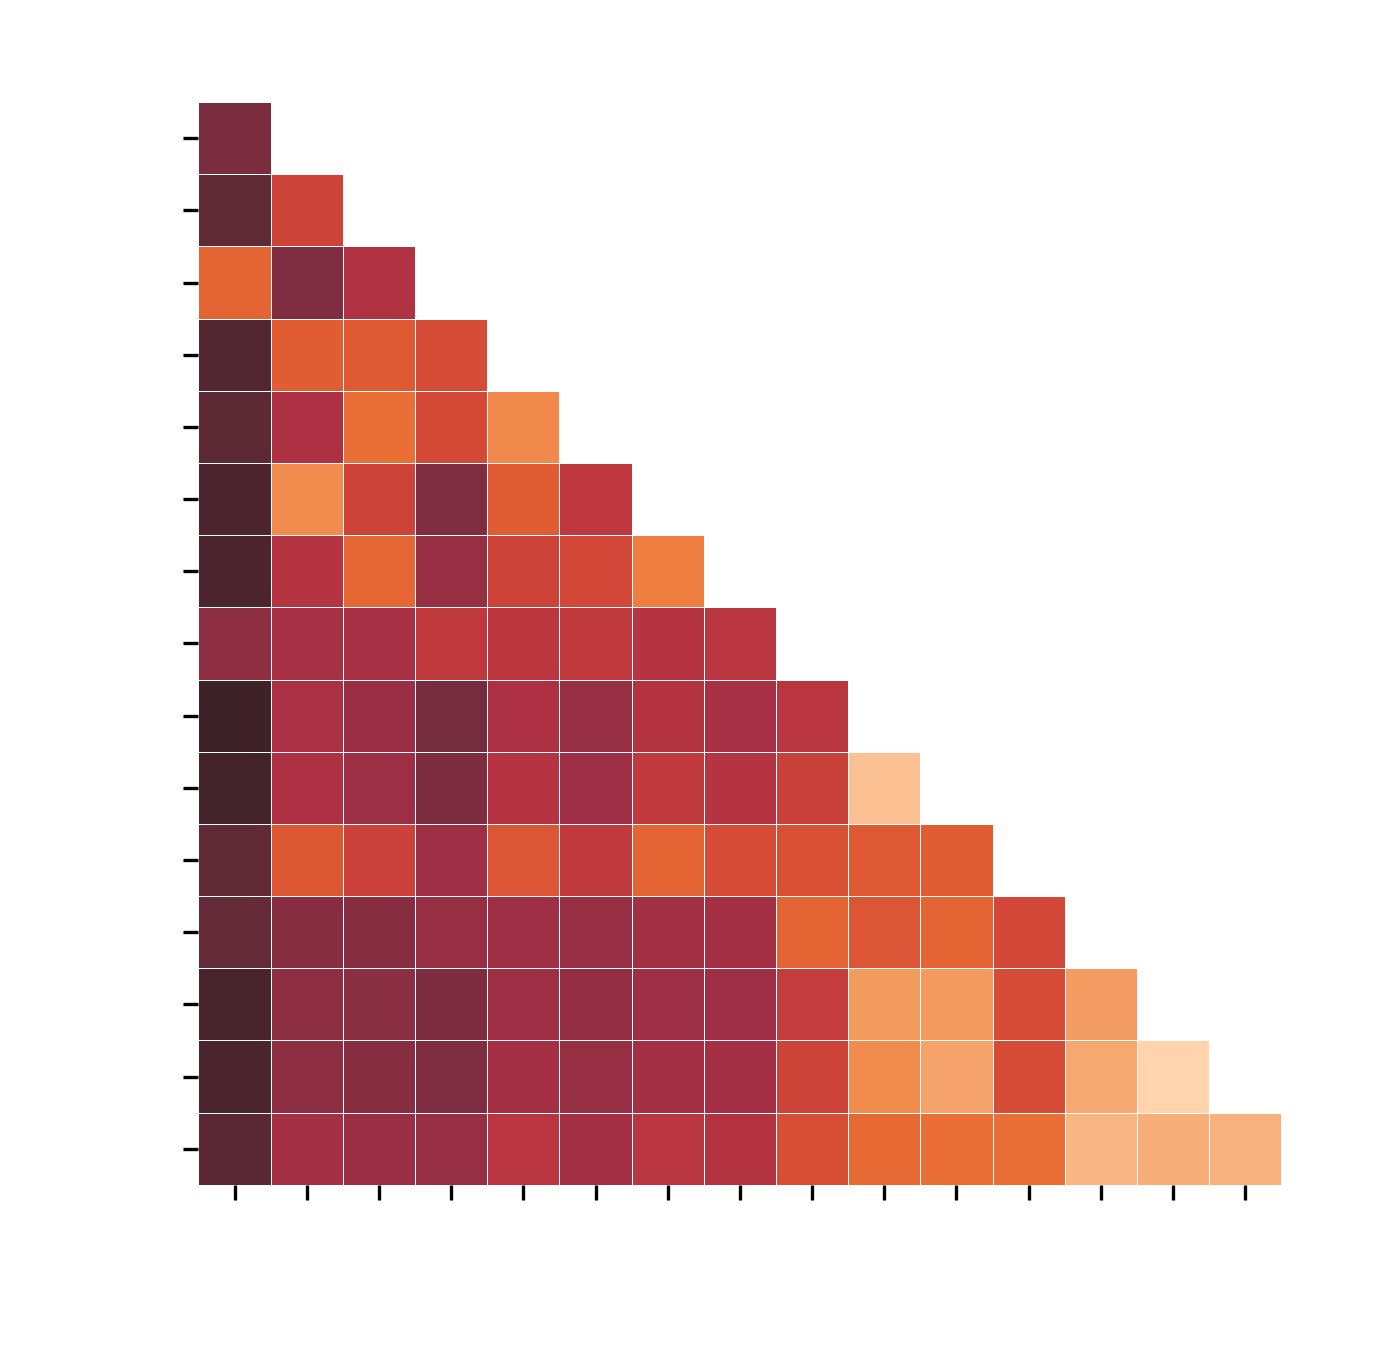

In [24]:
def plot_heatmap_qpp_similarities(df, title=None, save_figure=False, order=None):
    plt.close()
    mask = np.triu(np.ones_like(df, dtype=bool))
    if order is None:
        order = df.sum().sort_values().index
    g = sns.heatmap(df.loc[order, order].rename(PlotNames, axis=0).rename(PlotNames, axis=1), mask=mask, annot=True,
                    fmt=".2f", cbar=False, center=False, cmap=None, square=True, annot_kws={'fontsize': 6},
                    yticklabels=True, xticklabels=True, linewidths=.2)
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_yticklabels([None] + g.get_yticklabels()[1:], rotation=0, fontdict={'fontsize': 6})
    g.set_xticklabels(g.get_xticklabels()[:-1] + [None], rotation=50, fontdict={'fontsize': 6})
    g.set_xticks(g.get_xticks()[:-1])
    g.set_yticks(g.get_yticks()[1:])
    if title is not None:
        _title = []
        for s in title.split('_'):
            if s == 'indri' or s == 'porter':
                continue
            else:
                if s.islower():
                    s = s.title()
                _title.append(s)
        _title = ' '.join(_title)
        # plt.title(_title)
        plt.title(None)
    if save_figure:
        plt.savefig(title + '_heatmap.pdf', dpi=300, bbox_inches='tight')
    # plt.tight_layout()
    # plt.show()
    return order


PostRetPredictors.remove('qf')
PostRetPredictors.remove('uef-qf')
order = PreRetPredictors + PostRetPredictors
plot_heatmap_qpp_similarities(filter_robust_title_queries(predictions_df).corr(method='kendall'),
                              title='indri_porter_QPP_kendall-corr_title_queries', save_figure=True, order=order)

scq            0.299296
var            0.447042
avg-scq        0.486819
max-scq        0.488596
max-var        0.496361
max-idf        0.502477
avg-idf        0.519278
clarity        0.523908
avg-var        0.530297
smv            0.539490
uef-clarity    0.547232
uef-smv        0.557108
nqc            0.560235
uef-nqc        0.564071
wig            0.572965
uef-wig        0.576141
dtype: float64

In [5]:
ci_df = pd.read_pickle('data/thesis/smare_indri_porter_kendall_ci.pkl').sort_values(['queries', 'value'],
                                                                                    ascending=[False, True]).rename(
    PlotNames)
ci_df.index.rename('predictor', inplace=True)
ci_df

,value,queries
predictor,,
SCQ,0.010563,title
AvgSCQ,0.147027,title
SCQ,0.187718,title
SumVAR,0.188170,title
AvgIDF,0.201324,title
...,...,...
NQC,0.384901,all
UEF(Clarity),0.404019,all
UEF(SMV),0.405061,all


In [6]:
def count_different_pairs(df):
    order = df.loc[df['queries'] == 'title'].sort_values(['value']).index
    pairs = {}
    prev = order[0]
    for pred in order:
        first, last = np.where(pred == order)[0]
        pairs[pred] = 16 - (last - first)
    return pairs


different_pairs = count_different_pairs(ci_df)
sum(different_pairs.values())

56

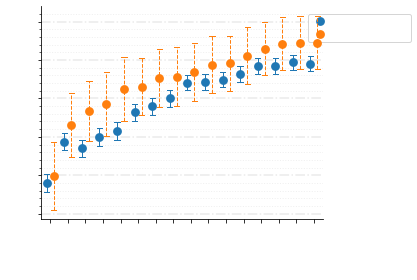

In [7]:
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(thesis_fmt)

capsize = 0.3
ax = sns.pointplot(data=ci_df, x=ci_df.index, y='value', hue='queries', join=False, dodge=0.4, linestyles=['-', '--'],
                   hue_order=['all', 'title'], errorbar=("pi", 100), errwidth=1, capsize=capsize)
# set z order of markers

first_half = len(ax.get_lines()) // 2

# make the errorbars dashed for one hue
for i, line in enumerate(ax.get_lines()[first_half:]):
    if i % 3:
        line.set_linestyle('-')
    else:
        line.set_linestyle('--')

sns.despine(right=True, top=True)

ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.grid(visible=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=0, linewidth=1.5,
        alpha=0.8)
ax.grid(visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=1, linewidth=1, alpha=0.6)

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100)

ax.set_ylabel("Kendall's $\\tau$")
ax.set_xlabel(None)
plt.xticks(rotation=45)

# remove the legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['With Query Variants', 'Title Query Only'], title=None, loc='center', ncol=1,
          frameon=True, bbox_to_anchor=(1.13, 0.9))

plt.tight_layout()
plt.savefig('robust_kendall_cis.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def read_eval_df(prefix_path, ir_metric):
    eval_file = ensure_file(f"{prefix_path}_QL.{ir_metric}")
    eval_df = pd.read_csv(eval_file, delim_whitespace=True, names=['qid', ir_metric], index_col=0)
    return eval_df.sort_index()


def read_prediction_files(prefix_path, r_type='all'):
    if r_type == 'all':
        # post_ret_predictors = glob(prefix_path + '_QL_g_*.pre')  # The g is used for the optimized parameters
        post_ret_predictors = glob(f'{prefix_path}_QL_*.pre')  # The g is used for the optimized parameters
        pre_ret_predictors = glob(prefix_path + f'*PRE*.pre')
        predictors = pre_ret_predictors + post_ret_predictors
    elif r_type.lower() == 'pre':
        predictors = glob(prefix_path + '*PRE*')
    else:
        # predictors = glob(prefix_path + '_QL_g_*.pre')  # The g is used for the optimized parameters
        predictors = glob(prefix_path + '_QL_*.pre')
    _results = []
    for _file in predictors:
        comps = _file.rsplit('/', 1)[1].replace('.pre', '').rsplit('_')
        assert 5 <= len(comps) <= 7, f'The predictions file {_file} has an unknown name format'
        if len(comps) == 7:
            collection, _, stemmer, stoplist, method, _, predictor = comps
        elif len(comps) == 6:
            # collection, stemmer, stoplist, method, predictor, part_name = comps
            collection, _, stemmer, stoplist, method, predictor = comps
        else:
            collection, stemmer, stoplist, method, predictor = comps
        _results.append(
            pd.read_csv(_file, delim_whitespace=True, names=['topic', 'qid', predictor],
                        dtype={'topic': str}).set_index(['topic', 'qid']))
    # return pd.concat(_results, axis=1).drop(['672', 672], errors='ignore') \
    #     .drop(ROBUST_DUPLICATED_QIDS, level=1, errors='ignore').sort_index() \
    #     .rename(columns=lambda x: '-'.join([i.split('+')[0] for i in x.split('-')]))
    return pd.concat(_results, axis=1).drop(['672', 672], errors='ignore').sort_index() \
        .rename(columns=lambda x: '-'.join([i.split('+')[0] for i in x.split('-')]))

Kendall corr 0.36


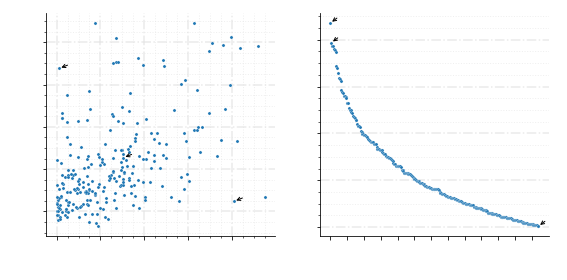

In [10]:
# def plot_scatter_predictor(prefix_path, ir_metric):  # Used for the DC presentation
prefix_path = './data/thesis/robust_krovetz_nostop_terrier'
ir_metric = 'ap@1000'
eval_sr = read_eval_df(prefix_path, ir_metric)[ir_metric]
predictions_df = read_prediction_files(prefix_path, r_type='post')
predictor_sr = predictions_df['nqc'].droplevel('topic')
# eff_sr = eval_sr
# eff_sr = (eff_sr - eff_sr.min()) / (eff_sr.max() - eff_sr.min()) * 0.1 + np.random.random(len(eval_sr)) * 0.009
df = pd.DataFrame({'AP': eval_sr.sort_index(), 'NQC': predictor_sr.sort_index()})
# df = pd.DataFrame({'AP': eval_sr.sort_index(), 'NQC': eff_sr.sort_index()})
_df = filter_robust_title_queries(df)
_df.index = _df.index.str[:3]
print(f'Kendall corr {_df.corr(method="kendall").iloc[0, 1]:.2g}')
sare_sr = _df.rank(ascending=False, pct=True).diff(axis=1).abs()['NQC'].sort_values(ascending=False)

# generate two subpplots in one row
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# ax[0].scatter(x=_df['AP'], y=_df['NQC'], zorder=2.5, linewidths=0.5, marker='o', s=20)#, edgecolor='c')
sns.scatterplot(x=_df['AP'], y=_df['NQC'], ax=ax[0], zorder=2.5, linewidths=0.5, s=10)
ax[0].set_xlabel('AP')
ax[0].set_ylabel('NQC')

# ax[1].scatter(x=sare_sr.index, y=sare_sr, zorder=2.5, linewidths=0.5, marker='o', s=20)#, edgecolor='c')
sns.scatterplot(x=sare_sr.index, y=sare_sr, ax=ax[1], zorder=2.5, linewidths=0.5, s=10)
x_tick_labels = ax[1].get_xticklabels()
# disable x ticks labels
# ax[1].set_xticklabels([])

#display only every 25th tick, and rotate the labels
n = 20
ax[1].set_xticks(range(0, len(x_tick_labels), n), x_tick_labels[::n], rotation=90)
# for i, label in enumerate(x_tick_labels):
#     if i % n == 0:
#         label.set_visible(True)
#         label.set_rotation(90)
#     else:
#         label.set_visible(False)

ax[1].set_ylabel('sARE')
ax[1].set_xlabel('Topic')

# add a diagonal line
# ax[0].axline(_df.min(), _df.max(), linewidth=0.8, color='slategray', linestyle=':')

ax[0].annotate(f'Kendall\'s $\\tau$ = {_df.corr(method="kendall").iloc[0, 1]:.2g}', (0.5, 1), size='medium',
               xycoords='axes fraction', ha='center', va='center')

sns.despine(right=True, top=True)

ax[0].minorticks_on()
ax[0].grid(visible=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=2.01, linewidth=1.5,
           alpha=0.8)
ax[0].grid(visible=True, which='minor', axis='both', color='#E5E5E5', linestyle=':', zorder=2, linewidth=1, alpha=0.6)

ax[1].yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1].grid(visible=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=2.01, linewidth=1.5,
           alpha=0.8)
ax[1].grid(visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=2, linewidth=1, alpha=0.6)
# outliers = _df.rank(ascending=False).diff(axis=1).abs()['NQC'].nlargest(2).index
# get first two and last elements from the sorted sr
outliers = sare_sr.iloc[[0, 1, -1]].index

for (i, x, y) in _df.loc[outliers].itertuples():
    ax[0].annotate(i, (x, y), size='small', xytext=(12, 5), textcoords='offset points',
                   arrowprops=dict(arrowstyle='->', color='black'))

jig = 10
for x, y in sare_sr.loc[outliers].items():
    ax[1].annotate(x, (x, y), size='small', xytext=(jig, jig), textcoords='offset points',
                   arrowprops=dict(arrowstyle='->', color='black'))
    # jig += 20

plt.tight_layout()
plt.savefig('robust_ap_nqc_scatter_sare_intuition.pdf', dpi=300, bbox_inches='tight')
plt.show()

,max-scq,avg-scq,avg-idf,max-var,scq,avg-var,max-idf,var,wig,nqc,smv,clarity,uef-wig,uef-nqc,uef-smv,uef-clarity
max-scq,1.000000,0.587073,0.500501,0.676025,0.291410,0.547628,0.602644,0.462560,0.497236,0.321188,0.305047,0.523477,0.447506,0.344876,0.334872,0.441719
avg-scq,0.587073,1.000000,0.795842,0.442979,0.030892,0.709192,0.408296,0.220706,0.660187,0.488690,0.454794,0.505451,0.477771,0.417379,0.397494,0.371528
avg-idf,0.500501,0.795842,1.000000,0.540661,-0.026621,0.750086,0.736376,0.228530,0.646489,0.594953,0.537634,0.515252,0.509453,0.524790,0.488989,0.410199
max-var,0.676025,0.442979,0.540661,1.000000,0.227149,0.779956,0.635935,0.596235,0.491479,0.467105,0.412927,0.534513,0.506330,0.502379,0.464532,0.500411
scq,0.291410,0.030892,-0.026621,0.227149,1.000000,-0.020960,0.211629,0.870122,0.096730,-0.191280,-0.204035,0.350143,0.141146,-0.078917,-0.092611,0.243450
avg-var,0.547628,0.709192,0.750086,0.779956,-0.020960,1.000000,0.511961,0.393036,0.643905,0.595054,0.531742,0.494906,0.563896,0.573612,0.531666,0.453097
max-idf,0.602644,0.408296,0.736376,0.635935,0.211629,0.511961,1.000000,0.407698,0.450890,0.449896,0.402233,0.507067,0.435723,0.448761,0.417889,0.440539
var,0.462560,0.220706,0.228530,0.596235,0.870122,0.393036,0.407698,1.000000,0.331858,0.079154,0.034114,0.497277,0.352637,0.171569,0.134786,0.402142
wig,0.497236,0.660187,0.646489,0.491479,0.096730,0.643905,0.450890,0.331858,1.000000,0.747698,0.721100,0.647710,0.835700,0.710204,0.697064,0.616393
nqc,0.321188,0.488690,0.594953,0.467105,-0.191280,0.595054,0.449896,0.079154,0.747698,1.000000,0.972287,0.539864,0.752887,0.935198,0.923906,0.626425


In [ ]:



def get_queries_object():
    queries_path, queries_type = (Config.TEXT_QUERIES, 'text') if Config.TEXT_QUERIES else \
        (Config.CIFF_QUERIES, 'ciff')
    if queries_path is None:
        raise AssertionError('No queries file was specified')
    return initialize_text_queries(queries_path) if queries_type == 'text' else initialize_ciff_queries(queries_path)


def set_index():
    if Config.TERRIER_INDEX:
        index_path, index_type = (Config.TERRIER_INDEX, 'terrier')
    else:
        index_path, index_type = (Config.INDEX_DIR, 'text') if Config.INDEX_DIR else (Config.CIFF_INDEX, 'ciff')
    if index_path is None:
        raise AssertionError('No index was specified')
    return index_path, index_type


def print_samples_ratios(data_df):
    logger.info(f'{data_df["label"].sum()} samples out of {len(data_df)} were marked positive')
    logger.info(f'Ratio of positive samples in the data: {data_df["label"].sum() / len(data_df) :.2f}')
    logger.info(f"Ratio of topics with positive samples: "
                f"{data_df[['topic', 'label']].groupby('topic').any().sum()[0] / len(data_df.groupby('topic')) :.2f}")


def read_query_sim_df(prefix_path, sim_metric):
    sim_file = ensure_file(f"{prefix_path}_pairwise_sim-{sim_metric}.tsv")
    try:
        return pd.read_csv(sim_file, delim_whitespace=True, index_col='qid')
    except KeyError:
        return pd.read_csv(sim_file, delim_whitespace=True).rename_axis('qid')


def generate_labeled_df(prefix_path, ir_metric, threshold):
    eval_df = read_eval_df(prefix_path, ir_metric)
    # return eval_df
    _threshold = eval_df.quantile(threshold)[0]
    logger.info(f"Threshold for bad queries was set to {_threshold:.3f}")
    # This will label all variants above the threshold as 0, and less eq than as 1
    labeled_df = eval_df.where(eval_df.to_numpy() <= _threshold, 0).mask(eval_df.to_numpy() <= _threshold, 1).rename(
        columns={ir_metric: 'label'})
    labeled_df = add_topic_to_qdf(labeled_df).set_index('qid')
    assert labeled_df['label'].sum() > 0, 'No samples were labeled as positive'
    print('\nSamples ratios in the data')
    print_samples_ratios(labeled_df)
    return labeled_df, _threshold


def read_lgbm_prediction_files(ir_metric, threshold=None):
    if threshold:
        try:
            _file = ensure_file(f'{ir_metric}_q-{threshold:.1f}_LGBM.pre')
        except FileNotFoundError as er:
            sys.exit(er)
        return pd.read_csv(_file, delim_whitespace=True, names=['qid', 'LGBM'], index_col=['qid'])
    else:
        predictors = glob(f'*{ir_metric}*' + '.pre')
    _results = []
    for _file in predictors:
        _ir_metric, threshold, predictor = _file.replace('.pre', '').split('_', 2)
        _results.append(
            pd.read_csv(_file, delim_whitespace=True, names=['qid', f'Q-{threshold}'], index_col=['qid']))
    return pd.concat(_results, axis=1)


def df_to_libsvm(df: pd.DataFrame, set_name):
    data_dir = ensure_dir('data')
    x = df.drop(['qid', 'topic', 'label'], axis=1)
    y = df['label']
    dump_svmlight_file(X=x, y=y, f=f'{data_dir}/{set_name}.txt', zero_based=True)


def generate_random_col(data_df):
    x = np.arange(len(data_df))
    np.random.shuffle(x)
    return x


# TODO: check this
def plot_hard_queries(prefix_path, ir_metric):
    predictors_group = 'post'
    eval_df = read_eval_df(prefix_path, ir_metric)
    predictions_df = read_prediction_files(prefix_path, r_type=predictors_group)
    data_df = predictions_df.merge(eval_df, left_on='qid', right_on='qid')
    data_df['random'] = generate_random_col(data_df)
    diff_df = data_df.drop(ir_metric, 1).rank(pct=True, ascending=False).subtract(
        data_df[ir_metric].rank(pct=True, ascending=False), axis=0)
    print(f'Number of evaluated queries: {len(diff_df)}')
    # for predictor in diff_df.columns:
    # print(f'{predictor}:')
    # print(f'Largest differences (ranked higher by predictor): {diff_df[predictor].nlargest(10)}')
    # print(f'Smallest differences (ranked lower by predictor): {diff_df[predictor].nsmallest(10)}')
    print(f'Poor queries that were predicted as good:')
    poorest = diff_df.min(1).nlargest(330).index
    print(f'poorest topics:')

    bad_topics = add_topic_to_qdf(eval_df).nlargest(330, ir_metric).topic
    for pred in diff_df.columns:
        poor_topics = add_topic_to_qdf(diff_df)[['topic', 'qid', pred]].nsmallest(330, pred).topic
        print(pred, overlap_coefficient(set(bad_topics), set(poor_topics)))
    bad_topics = add_topic_to_qdf(eval_df).nsmallest(330, ir_metric).topic
    for pred in diff_df.columns:
        poor_topics = add_topic_to_qdf(diff_df)[['topic', 'qid', pred]].nsmallest(330, pred).topic
        print(pred, overlap_coefficient(set(bad_topics), set(poor_topics)))
    bad_queries = eval_df.nsmallest(330, ir_metric).index
    # print(overlap_coefficient(set(bad_topics), set(add_topic_to_qdf(diff_df.min(1).nlargest(15)).topic)))
    print('poorest queries:')
    print(overlap_coefficient(set(bad_queries), set(diff_df.min(1).nlargest(330).index)))
    # plot_qq_plot(diff_df, False)
    plot_predictors_errors(diff_df.pow(2), title=f'{predictors_group.capitalize()}-Retrieval squared difference',
                           save_figure=False)
    # plot_hard_topics(diff_df.loc[diff_df.loc[poorest].T.median().sort_values().index].T, ir_metric)
    # diff_df = add_topic_to_qdf(diff_df)
    # sns.pairplot(diff_df.set_index('qid').groupby('topic').median())
    # sns.pairplot(diff_df, markers='*')
    # plt.show()
    # diff_df.to_pickle(f'diff_df_{ir_metric}.pkl')

    # exit()


def plot_hard_topics(topics_df, ir_metric):
    # plt.rcParams.update({'font.size': 16, 'font.family': 'serif'})
    fig, ax = plt.subplots(figsize=(16, 9), dpi=100, facecolor='w', edgecolor='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # fig, ax = plt.subplots()
    # sns.set(font='serif', font_scale=2)
    fig.suptitle(f'Top Ranking Errors by Query {ir_metric}')
    # Create the boxplot and store the resulting python dictionary
    boxes = ax.boxplot(topics_df.to_numpy())
    ax.set_xticklabels(topics_df.columns, rotation=45)
    make_flier_labels(ax, boxes, topics_df)
    plt.tight_layout()
    plt.show()
    # fig.savefig(f'top_15_ranking_errors_{ir_metric}.eps')


def make_flier_labels(ax, boxplots, df):
    for i, box in enumerate(boxplots['fliers']):
        fly = box
        # The x position of the flyers
        x_pos = boxplots['medians'][i].get_xdata()

        # Add text a horizontal offset as a fraction of the width of the box
        x_off = 0.10 * (x_pos[1] - x_pos[0])
        sr = df.iloc[:, i]
        eps = 0.0001
        for flier in fly.get_ydata():
            predictor = sr.loc[(flier - eps <= sr) & (sr <= flier + eps)].index[0]
            ax.annotate(f' {predictor}', (1 + i + x_off, flier), xytext=(0, -3), textcoords="offset points",
                        ha='center',
                        va='top')


def generate_baselines_results(data_df):
    auc_res = []
    for predictor in data_df.drop(['topic', 'label'], 1).columns:
        auc_res.append((predictor, roc_auc_score(data_df['label'], -data_df[predictor])))
        # plot_roc(data_df['label'], -data_df[predictor], predictor)
    return pd.DataFrame(auc_res, columns=['Predictor', 'AUC-ROC']).set_index('Predictor')


def print_baselines_table_by_threshold(prefix_path, ir_metric):
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
    res = []
    for t in thresholds:
        data_df, threshold = generate_data_df(prefix_path, ir_metric, t)
        # nc = NestedCrossVal(data_df=data_df)
        # nc.outer_evaluation(f'{ir_metric}_q-{t:.1f}')
        lgbm_score = roc_auc_score(data_df['label'], read_lgbm_prediction_files(ir_metric, t))
        _df = generate_baselines_results(data_df).rename({'AUC-ROC': f'Q={t:.1f} T={threshold:.3f}'}, axis=1)
        _df.loc['LightGBM'] = lgbm_score
        res.append(_df)
    df = pd.concat(res, 1)
    df = df.reindex(df.mean(1).sort_values().index)
    df.columns = pd.MultiIndex.from_product([[ir_metric], df.columns])
    print(df.to_latex(multicolumn=True, float_format='%.3f', column_format='lccccc'))
    return df


def calc_correlations_df(predictions_df: pd.DataFrame, eval_df, title_only=False):
    results_pearson = []
    results_kendall = []
    if title_only:
        eval_df = filter_robust_title_queries(eval_df)
    for pred in predictions_df.columns:
        results_pearson.append(
            (pred,
             eval_df.merge(predictions_df[pred], left_index=True, right_on='qid').corr('pearson').to_numpy()[0][1]))
        results_kendall.append(
            (pred,
             eval_df.merge(predictions_df[pred], left_index=True, right_on='qid').corr('kendall').to_numpy()[0][1]))

    p_corrs_df = pd.DataFrame(results_pearson, columns=['predictor', 'pearson correlation']).set_index('predictor')
    k_corrs_df = pd.DataFrame(results_kendall, columns=['predictor', 'kendall correlation']).set_index('predictor')
    corrs_df = p_corrs_df.merge(k_corrs_df, left_index=True, right_index=True).sort_values('pearson correlation')
    corrs_df = corrs_df.assign(
        rank_diff=corrs_df['pearson correlation'].rank() - corrs_df['kendall correlation'].rank())
    print(corrs_df.to_latex(float_format='%.3f', column_format='lccc'))
    return corrs_df


def generate_data_df(prefix_path, ir_metric, quantile_threshold):
    labeled_df, threshold = generate_labeled_df(prefix_path, ir_metric, quantile_threshold)
    predictions_df = read_prediction_files(prefix_path)
    return predictions_df.merge(labeled_df, left_on='qid', right_on='qid'), threshold


def plot_dist(data_sr, title='', xlabel=None, ylabel='Density', save_figure=False):
    """
    KDE = kernel density estimation (KDE) is a non-parametric way to estimate the
    probability density function of a random variable.
    """
    titles = {'ndcg@10': 'nDCG@10', 'ndcg@100': 'nDCG@100', 'ap@1000': 'AP@1000'}
    # sns.set_color_codes("muted")  # {deep, muted, pastel, dark, bright, colorblind}
    # sns.set(font='serif', font_scale=2)
    # sns.set_style("white")
    # sns.set_palette("PuBuGn_d")
    # plt.figure(figsize=(7, 4), dpi=100)
    sns.distplot(data_sr, hist=False, rug=True, kde=True,
                 # fit_kws={"lw": 2, "label": "FIT"},
                 rug_kws={'color': '#2F4C56', "alpha": 0.2},
                 kde_kws={"lw": 2, "label": "KDE", "bw": "silverman"},
                 hist_kws={"histtype": "bar", "lw": 1, "alpha": 0.5})  # fit=stats.gamma to fit gamma function
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(titles.get(title, title))
    plt.tight_layout()
    sns.despine(left=True)
    if save_figure:
        plt.savefig(f'{title}_dist.pdf')
    else:
        # return
        plt.show()


# TODO: check this
def plot_eval_metrics_dist(prefix_path):
    def _poor_topics(_eval_df, _ir_metric, _n):
        # return add_topic_to_qdf(_eval_df.nsmallest(_n, _ir_metric)).topic
        return add_topic_to_qdf(_eval_df.nsmallest(_n, _ir_metric)).qid

    # save_figures = True
    save_figures = False
    ir_metric = 'ap@1000'
    ap_eval_df = read_eval_df(prefix_path, ir_metric)
    n = len(ap_eval_df) // 10
    # plot_dist(ap_eval_df, title=ir_metric, save_figure=save_figures)
    poor_ap_topics = set(_poor_topics(ap_eval_df, ir_metric, n))
    ir_metric = 'ndcg@100'
    ndcg_100_eval_df = read_eval_df(prefix_path, ir_metric)
    ap_eval_df.corrwith(ndcg_100_eval_df)
    # plot_dist(ndcg_100_eval_df, title=ir_metric, save_figure=save_figures)
    poor_ndcg_100_topics = set(_poor_topics(ndcg_100_eval_df, ir_metric, n))
    ir_metric = 'ndcg@10'
    ndcg_10_eval_df = read_eval_df(prefix_path, ir_metric)
    ir_metric = 'rbp-0.5'
    rbp_eval_df = read_eval_df(prefix_path, ir_metric)
    plot_dist(rbp_eval_df, title=ir_metric, save_figure=save_figures)
    poor_ndcg_10_topics = set(_poor_topics(ndcg_10_eval_df, ir_metric, n))
    print(f'{n} is ~10% of the data, printing coefficients of the {n} worst topics:')
    print('Overlap coefficient of AP-nDCG@100:')
    print(overlap_coefficient(poor_ap_topics, poor_ndcg_100_topics))
    print('Overlap coefficient of AP-nDCG@10:')
    print(overlap_coefficient(poor_ap_topics, poor_ndcg_10_topics))
    print('Overlap coefficient of nDCG@100-nDCG@10:')
    print(overlap_coefficient(poor_ndcg_100_topics, poor_ndcg_10_topics))
    eval_df = pd.concat([ap_eval_df.sort_index(), ndcg_100_eval_df.sort_index(), ndcg_10_eval_df.sort_index()], axis=1)
    eval_df.corr(method='kendall')


# TODO: check this
def plot_predictors_errors(diff_df: pd.DataFrame, title='', subplots=True, save_figure=False):
    # plt.rcParams.update({
    #     "text.usetex": True,
    #     "font.family": "sans-serif",
    #     "font.sans-serif": ["Helvetica"]})
    # plt.rcParams.update({'font.size': 20, 'font.family': 'serif'})
    plt.figure(figsize=(16, 9), dpi=100)
    ax = diff_df[diff_df.median().sort_values().index].boxplot()
    plt.xticks(rotation=45)
    if save_figure:
        plt.savefig(f'prediction_errors_box.pdf')
    else:
        plt.show()
    if subplots:
        plt.figure(figsize=(16, 9), dpi=100)
        for pred in diff_df.median().sort_values().index:
            sns.distplot(diff_df[pred], hist=False, rug=True, kde=True, label=pred,
                         # fit_kws={"lw": 2, "label": "FIT"},
                         # rug_kws={'color': '#2F4C56', "alpha": 0.2},
                         kde_kws={"lw": 2, "label": "KDE", "clip": (0, 1), "bw": "silverman"})
        plt.title(title)
        plt.xlabel('Ranks Difference')
        plt.ylabel('Density')
        plt.grid()
        if save_figure:
            plt.savefig(f'prediction_errors_dist_{title.replace(" ", "_")}.pdf')
        else:
            plt.show()
    else:
        # _df = diff_df.melt()
        # g = sns.FacetGrid(_df, col="variable", col_wrap=PLOTS_COL_WRAP, height=1.5)
        # g = g.map(sns.distplot, "value")
        # plt.show()
        # exit()
        # plt.rcParams.update({
        #     "text.usetex": True,
        #     "font.family": "sans-serif",
        #     "font.sans-serif": ["Helvetica"]})
        for pred in diff_df.columns:
            sns.distplot(diff_df[pred], hist=False, rug=True, kde=True, label=pred,
                         fit_kws={"lw": 2, "label": "FIT"},
                         rug_kws={'color': '#2F4C56', "alpha": 0.2},
                         kde_kws={"lw": 2, "label": "KDE", "clip": (0, 1), "bw": "silverman"},
                         hist_kws={"histtype": "bar", "lw": 1, "alpha": 0.5})
            plot_dist(diff_df[pred], title=pred + ' Error', save_figure=save_figure)


def plot_qq_plot(diff_df, save_figure=False):
    for pred in diff_df.columns:
        # plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
        # sns.set(font='serif')
        # sns.set_style("white")
        # sns.set_palette("PuBuGn_d")
        plt.figure(figsize=(7, 4), dpi=100)
        fig = sm.qqplot(diff_df[pred], line='s', color='#2F4C56')
        fig.set_size_inches((7, 4))
        fig.set_dpi(100)
        fig.tight_layout()
        if save_figure:
            fig.savefig(f'prediction_errors_box.pdf')
        else:
            fig.show()


def plot_predictors_dist(prefix_path):
    predictions_df = read_prediction_files(prefix_path, r_type='pre').reset_index('topic', drop=True)
    for pred in predictions_df.columns:
        plot_dist(predictions_df[pred], title=pred, save_figure=False)


def eval_to_rank_map(eval_df, predictions_df, ranks_method):
    ir_metric = eval_df.columns[0]
    rank_ap_dict = eval_df.assign(rank=eval_df.rank(ascending=False, method=ranks_method)).set_index('rank')[
        ir_metric].to_dict()
    df = predictions_df.rank(ascending=False, method=ranks_method).applymap(
        lambda x: rank_ap_dict.get(x, find_closest_key(x, rank_ap_dict)))
    diff_df = df.subtract(eval_df[ir_metric], axis=0)
    return diff_df


def find_closest_key(val, dict_val):
    return dict_val.get(min(dict_val.keys(), key=lambda x: abs(x - val)))


def test_for_normality(data_sr, alpha=5e-2, title=None):
    """
    Noramlity test that based on D'Agostino and
    Pearson's test that combines skew and kurtosis to
    produce an omnibus test of normality
    :param data_sr:
    :rtype: bool
    :return True if data is normally distributed False otherwise
    """
    if len(data_sr) >= 20:
        stat, p = stats.normaltest(data_sr)
    else:
        logger.info('The sample size is smaller than 20, using Shapiro test')
        stat, p = stats.shapiro(data_sr)
    logger.debug(f'p value = {p}')
    if p < alpha:  # null hypothesis: data_sr comes from a normal distribution
        logger.info(
            f'{title.capitalize()} is not normally distributed with sig level {alpha}') if title else logger.info(
            f'The result is not normally distributed with sig level {alpha}')
        return False
    else:
        logger.info(f'{title.capitalize()} is normally distributed with sig level {alpha}') if title else logger.info(
            f'The result is normally distributed with sig level {alpha}')
        return True


def test_variance_equality(*args, alpha=5e-2):
    """
    The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
    Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances.
    :param args:
    :param alpha:
    :return:
    """
    stat, p = stats.levene(args)
    logger.debug(f'p value = {p}')
    if p < alpha:  # null hypothesis: data_sr comes from a normal distribution
        logger.info(f'The results does not have equal variances with sig level {alpha}')
        return False
    else:
        logger.info(f'The results do have equal variances with sig level {alpha}')
        return True


def construct_pairwise_df(sr: pd.Series, np_fun):
    """Constructs an upper diagonal df from all pairwise comparisons of a sr"""
    sr = sr.sort_index()
    _mat = np.triu(np_fun(sr.to_numpy() - sr.to_numpy()[:, None]), k=1)
    _mat[np.tril_indices(_mat.shape[0])] = None
    return pd.DataFrame(_mat, index=sr.index.get_level_values('qid'),
                        columns=sr.index.get_level_values('qid')).rename_axis(index='qid_1', columns='qid_2')


def clear_triangular_df(df: pd.DataFrame):
    """Clear all values under the diagonal (including diagonal) for a square df"""
    _mat = df.to_numpy()
    _mat[np.tril_indices(_mat.shape[0])] = None
    return pd.DataFrame(_mat, index=df.index, columns=df.index)


def construct_sampled_inter_df(eval_df, predictions_df, n, sim_df):
    _res = []
    for _ in range(n):
        ev_sr = eval_df.groupby('topic').sample(1).iloc[:, 0]
        _ev_sgn = construct_pairwise_df(ev_sr, np.sign).stack()
        _ev_diff = construct_pairwise_df(ev_sr, np.abs).stack()
        _sim_df = sim_df.stack().loc[_ev_diff.index]
        for predictor, _sr in predictions_df.loc[ev_sr.index].iteritems():
            _pr_sgn = construct_pairwise_df(_sr, np.sign).stack()
            _df = pd.DataFrame({'sim': _sim_df, 'diff': _ev_diff, 'status': _ev_sgn == _pr_sgn}, index=_ev_diff.index)
            _res.append(_df.reset_index(drop=True).assign(predictor=predictor))
    return pd.concat(_res).sort_values(['predictor', 'diff', 'status']).reset_index(drop=True)
    # df['status'] = df['status'].map({0: 'wrong', 1: 'correct'})
    # return _df


def construct_full_pairwise_inter_df(eval_df, predictions_df, sim_df):
    _res = []
    intra_topic_index = eval_df.iloc[:, 0].groupby('topic').apply(
        lambda x: construct_pairwise_df(x, np.abs)).stack().index.droplevel(0)
    # ev_sr = eval_df.groupby('topic').sample(1).iloc[:, 0]
    _ev_sgn = construct_pairwise_df(eval_df.iloc[:, 0], np.sign).stack()
    _ev_diff = construct_pairwise_df(eval_df.iloc[:, 0], np.abs).stack()
    _sim_df = sim_df.stack()
    for predictor, _sr in predictions_df.iteritems():
        _pr_sgn = construct_pairwise_df(_sr, np.sign).stack()
        _pr_diff = construct_pairwise_df(_sr, np.abs).stack()
        _df = pd.DataFrame({'sim': _sim_df, 'ev_diff': _ev_diff, 'pr_diff': _pr_diff, 'status': _ev_sgn == _pr_sgn},
                           index=_ev_diff.index).drop(intra_topic_index)
        _res.append(_df.reset_index().assign(predictor=predictor))
    return pd.concat(_res).sort_values(['predictor', 'ev_diff', 'pr_diff', 'status']).reset_index(drop=True)


def construct_inter_sampled_to_intra_df(eval_df, predictions_df, sim_df):
    _res = []
    _round = 4
    intra_topic_df = eval_df.iloc[:, 0].groupby('topic').apply(
        lambda x: construct_pairwise_df(x, np.abs)).stack().round(_round)
    # w = intra_topic_df.reset_index(drop=True).round(2).value_counts().sort_index()
    # w = pd.cut(intra_topic_df, bins=100, precision=3, include_lowest=True)
    w, bins = pd.cut(intra_topic_df, bins=100, precision=3, include_lowest=True, retbins=True)
    bins[0] = 0
    bins[-1] = 1
    w = w.replace({w.min(): pd.Interval(0, w.min().right, closed='both')}).replace(
        {w.max(): pd.Interval(w.max().left, 1, closed='right')})
    w = w.groupby(w).count()
    intra_topic_index = intra_topic_df.index.droplevel(0)
    _ev_diff = construct_pairwise_df(eval_df.iloc[:, 0], np.abs).stack().round(_round)
    # x = pd.cut(_ev_diff.drop(intra_topic_index), bins=100, precision=3, include_lowest=True)
    x = pd.cut(_ev_diff.drop(intra_topic_index), bins=bins, precision=3, include_lowest=True)
    x = x.replace({x.min(): pd.Interval(0, x.min().right, closed='both')})
    x.index.rename(['qid_1', 'qid_2'], inplace=True)
    sampled_qids = pd.MultiIndex.from_frame(
        x.reset_index().groupby(0).apply(lambda x: x.sample(w.loc[x.name])).reset_index(drop=True)[['qid_1', 'qid_2']])
    _sim_df = sim_df.stack().loc[sampled_qids]
    _ev_sgn = construct_pairwise_df(eval_df.iloc[:, 0], np.sign).stack().loc[sampled_qids]
    _ev_diff = _ev_diff.loc[sampled_qids]
    for predictor, _sr in predictions_df.iteritems():
        _pr_sgn = construct_pairwise_df(_sr, np.sign).stack().loc[sampled_qids]
        _pr_diff = construct_pairwise_df(_sr, np.abs).stack().loc[sampled_qids]
        _df = pd.DataFrame({'sim': _sim_df, 'ev_diff': _ev_diff, 'pr_diff': _pr_diff, 'status': _ev_sgn == _pr_sgn},
                           index=_ev_diff.index)
        _res.append(_df.reset_index().assign(predictor=predictor))
    return pd.concat(_res).sort_values(['predictor', 'ev_diff', 'pr_diff', 'status']).reset_index(drop=True)


def load_generate_pickle_df(file_name, func, *args):
    if isinstance(file_name, (list, tuple, set)):
        single_file = False
    else:
        single_file = True
    try:
        if single_file:
            result = pd.read_pickle(file_name)
        else:
            result = [pd.read_pickle(_file) for _file in file_name]
    except FileNotFoundError:
        logger.warning(f'Failed to load {file_name}')
        logger.warning(f'Generating a new df and saving')
        result = func(*args)
        if single_file:
            result.to_pickle(file_name)
        else:
            assert len(result) == len(
                file_name), f'The number of objects returned by the function and number of files differ'
            [_res.to_pickle(_file) for (_res, _file) in zip(result, file_name)]
    return result


@timer
def inter_topic_pairwise_analysis(eval_df, predictions_df, similarities_df, prefix, n=None, load_cache=True,
                                  sample=False):
    ir_metric = eval_df.columns[0]
    n = n or 'all'
    if load_cache:
        if sample:
            df = load_generate_pickle_df(f'{prefix}_inter_topic_pairwise_{ir_metric}_df_{n}.pkl',
                                         construct_sampled_inter_df, eval_df, predictions_df, n, similarities_df)
        else:
            df = load_generate_pickle_df(f'{prefix}_inter_topic_pairwise_{ir_metric}_df_{n}.pkl',
                                         construct_full_pairwise_inter_df, eval_df, predictions_df, similarities_df)
    else:
        if sample:
            df = construct_sampled_inter_df(eval_df, predictions_df, n, similarities_df)
        else:
            df = construct_full_pairwise_inter_df(eval_df, predictions_df, similarities_df)
    # intra_df = eval_df.iloc[:, 0].groupby('topic').apply(
    #     lambda x: construct_pairwise_df(x, np.abs)).stack().reset_index(drop=True).rename('diff')
    # dd = pd.concat(
    #     [pd.DataFrame(df.loc[df['predictor'] == 'clarity', ['diff']]).assign(kind='inter').reset_index(drop=True),
    #      pd.DataFrame(intra_df).assign(kind='intra')])
    # dd.to_pickle(f'all_pairs_{ir_metric}_diff.pkl')
    log_pairwise_stats(df, 'Inter-topic', ir_metric)
    p = 2

    _gpd_df = df.round(p).groupby(['predictor', 'ev_diff'])['status']
    _freq_df = (_gpd_df.sum() / _gpd_df.count()).fillna(0).reset_index().rename({'status': 'freq'}, axis=1).assign(
        sample_size=_gpd_df.count().to_numpy())
    # df['status'] = df['status'].map({False: 'wrong', True: 'correct'})
    plot_pairwise_freq_diff(df.round(4), f'Inter-topic {n} samples {PlotNames.get(ir_metric, ir_metric)}', ir_metric)
    plot_pairwise_freq_diff_rel(_freq_df, f'Inter-topic {n} samples {PlotNames.get(ir_metric, ir_metric)}', ir_metric)

    _p = 4
    _gpd_df = df.round(p).groupby(['predictor', 'pr_diff'])['status']
    _freq_df = (_gpd_df.sum() / _gpd_df.count()).fillna(0).reset_index().rename({'status': 'freq'}, axis=1).assign(
        sample_size=_gpd_df.count().to_numpy())
    plot_pairwise_freq_diff(df.round(4), f'Inter-topic {n} samples {PlotNames.get(ir_metric, ir_metric)}', 'Predictor',
                            diff_col='pr_diff')
    plot_pairwise_freq_diff_rel(_freq_df, f'Inter-topic {n} samples {PlotNames.get(ir_metric, ir_metric)}', 'Predictor',
                                diff_col='pr_diff')

    # plot_pairwise_freq_sim(df, f'Inter-topic {n} samples similarity {ir_metric}')

    return df


def construct_intra_topic_df(eval_df, predictions_df, similarities_df):
    _res = []
    # freq_res = []
    _ev_sgn = eval_df.iloc[:, 0].groupby('topic').apply(lambda x: construct_pairwise_df(x, np.sign)).stack()
    _ev_diff = eval_df.iloc[:, 0].groupby('topic').apply(lambda x: construct_pairwise_df(x, np.abs)).stack()
    sim_df = similarities_df.stack().loc[_ev_diff.reset_index('topic', drop=True).index.to_numpy()]
    for predictor, _sr in predictions_df.iteritems():
        _pr_sgn = _sr.groupby('topic').apply(lambda x: construct_pairwise_df(x, np.sign)).stack()
        _pr_diff = _sr.groupby('topic').apply(lambda x: construct_pairwise_df(x, np.abs)).stack()
        _df = pd.DataFrame({'ev_diff': _ev_diff, 'pr_diff': _pr_diff, 'status': _ev_sgn == _pr_sgn},
                           index=_ev_diff.index).reset_index('topic', drop=True).assign(sim=sim_df)
        logger.debug(f'Number of tied ev pairs: {len(_ev_sgn.loc[_ev_sgn == 0].index.droplevel(0))}')
        logger.debug(f'Number of tied {predictor} pairs: {len(_pr_sgn.loc[_pr_sgn == 0].index.droplevel(0))}')
        _res.append(_df.reset_index().rename(columns={'level_1': 'qid_2'}).assign(predictor=predictor))
    return pd.concat(_res).sort_values(['predictor', 'ev_diff', 'status']).reset_index(drop=True)


@timer
def intra_topic_pairwise_analysis(eval_df, predictions_df, similarities_df, prefix, load_cache=False):
    ir_metric = eval_df.columns[0]
    if load_cache:
        df = load_generate_pickle_df(f'{prefix}_intra_topic_pairwise_{ir_metric}_df.pkl', construct_intra_topic_df,
                                     eval_df, predictions_df, similarities_df)
    else:
        df = construct_intra_topic_df(eval_df, predictions_df, similarities_df)
    log_pairwise_stats(df, 'Intra-topic', ir_metric)
    p = 2
    _gpd_df = df.round(p).groupby(['predictor', 'ev_diff'])['status']
    _freq_df = (_gpd_df.sum() / _gpd_df.count()).fillna(0).reset_index().rename({'status': 'freq'}, axis=1).assign(
        sample_size=_gpd_df.count().to_numpy())
    plot_pairwise_freq_diff(df.round(4), f'Intra-topic all pairs {PlotNames.get(ir_metric, ir_metric)}', ir_metric,
                            diff_col='ev_diff')
    plot_pairwise_freq_diff_rel(_freq_df, f'Intra-topic all pairs {PlotNames.get(ir_metric, ir_metric)}', ir_metric,
                                diff_col='ev_diff')
    _p = 4
    _gpd_df = df.round(_p).groupby(['predictor', 'pr_diff'])['status']
    _freq_df = (_gpd_df.sum() / _gpd_df.count()).fillna(0).reset_index().rename({'status': 'freq'}, axis=1).assign(
        sample_size=_gpd_df.count().to_numpy())
    plot_pairwise_freq_diff(df.round(4), f'Intra-topic all pairs {PlotNames.get(ir_metric, ir_metric)}', 'Predictor',
                            diff_col='pr_diff')
    plot_pairwise_freq_diff_rel(_freq_df, f'Intra-topic all pairs {PlotNames.get(ir_metric, ir_metric)}', 'Predictor',
                                diff_col='pr_diff')

    plot_pairwise_freq_sim(df, f'Intra-topic all pairs similarity {ir_metric}')
    return df


def plot_pairwise_freq_sim(df, title):
    if df.loc[df.predictor == df.predictor[0]].sim.nunique() / len(df.loc[df.predictor == df.predictor[0]]) < 0.001:
        lowess = False
    else:
        lowess = True
    g = sns.lmplot(data=df.loc[df.predictor == df.predictor[0]], y='ev_diff', x='sim', hue='status', markers=["+", "x"],
                   scatter_kws={"alpha": 0.2}, line_kws={'lw': 2}, lowess=lowess, x_jitter=0.01)
    print('Using lowess correlation') if lowess else print('Using linear correlation')
    g.set_axis_labels("Similarity", "Metric Diff")
    g.tight_layout()
    plt.show()
    _gpd_df = df.groupby(['predictor', 'sim'])['status']
    _freq_df = (_gpd_df.sum() / _gpd_df.count()).fillna(0).reset_index().rename({'status': 'freq'}, axis=1).assign(
        sample_size=_gpd_df.count().to_numpy())
    plot_pairwise_freq_diff(df, title, 'Cosine sim', diff_col='sim')
    plot_pairwise_freq_diff_rel(_freq_df, title, 'Cosine sim', diff_col='sim')


def plot_pairwise_freq_diff_rel(_freq_df, title, ir_metric, diff_col='ev_diff'):
    n_predictors = _freq_df['predictor'].nunique()
    _title = f'freq_given_diff_{n_predictors}_predictors_{title.replace(" ", "_").lower()}'

    def plot_regplots(**kwargs):
        sns.regplot(x=diff_col, y='freq', lowess=True,
                    scatter_kws={'s': 5 * np.log2(kwargs['data']['sample_size']) + 2}, **kwargs)

    if diff_col == 'pr_diff':
        g2 = sns.FacetGrid(_freq_df, col="predictor", col_wrap=PLOTS_COL_WRAP, sharex=False, sharey=False)
        g2.map_dataframe(plot_regplots)
    else:
        g2 = sns.lmplot(data=_freq_df, x=diff_col, y='freq', col='predictor', lowess=True, col_wrap=PLOTS_COL_WRAP,
                        scatter_kws={
                            's': 5 * np.log2(_freq_df.head(int(len(_freq_df) / n_predictors))['sample_size']) + 2})
    g2.set_axis_labels(f"{PlotNames.get(ir_metric, ir_metric)} difference", "Correct Ratio")
    g2.set_titles(title + " {col_name} predictor")
    g2.tight_layout()
    g2.savefig(f'{_title}_{diff_col}_reg.pdf')
    plt.show()
    _freq_df = _freq_df.rename({diff_col: f"{PlotNames.get(ir_metric, ir_metric)} diff"})
    g3 = sns.pairplot(data=_freq_df, hue='predictor')
    plt.savefig(f'{_title}_{diff_col}_pairplot.pdf')
    plt.show()


def plot_pairwise_freq_diff(_df, title, ir_metric, diff_col='ev_diff'):
    n_predictors = _df['predictor'].nunique()
    _title = f'estimating_freq_given_diff_{n_predictors}_predictors_{title.replace(" ", "_").lower()}'
    if diff_col == 'pr_diff':
        g1 = sns.displot(data=_df, x=diff_col, col='predictor', hue='status', stat="density", element='step',
                         col_wrap=PLOTS_COL_WRAP, common_bins=False, facet_kws={'sharex': None, 'sharey': False})
    else:
        g1 = sns.displot(data=_df, x=diff_col, col='predictor', col_wrap=PLOTS_COL_WRAP, hue='status', stat="density",
                         element='step')
    g1.set_axis_labels(f"{PlotNames.get(ir_metric, ir_metric)} difference", "Density")
    g1.set_titles(title + " {col_name} predictor")
    plt.tight_layout()
    plt.savefig(f'{_title}_{ir_metric.replace(" ", "_").lower()}_hist.pdf')
    plt.show()
    if diff_col == 'pr_diff':
        g11 = sns.displot(data=_df, x=diff_col, col='predictor', hue='status', kind='kde', clip=(0.0, 1.0), fill=True,
                          alpha=0.5, col_wrap=PLOTS_COL_WRAP, facet_kws={'sharex': False, 'sharey': False})
    else:
        g11 = sns.displot(data=_df, x=diff_col, col='predictor', hue='status', kind='kde', clip=(0.0, 1.0), fill=True,
                          col_wrap=PLOTS_COL_WRAP, alpha=0.5)
    g11.set_axis_labels(f"{PlotNames.get(ir_metric, ir_metric)} difference", "Density")
    g11.set_titles(title + " {col_name} predictor")
    plt.tight_layout()
    plt.savefig(f'{_title}_{ir_metric.replace(" ", "_").lower()}_kde.pdf')
    plt.show()


def inter_topic_eval(ir_metric, prefix_path, similarities_df):
    predictors_type = 'all'
    eval_df = add_topic_to_qdf(read_eval_df(prefix_path, ir_metric)).set_index(['topic', 'qid'])
    predictions_df = read_prediction_files(prefix_path, r_type=predictors_type)
    # sim_df = clear_triangular_df(similarities_df)
    # predictions_df = predictions_df[['qf', 'nqc', 'uef-wig']]
    # predictions_df = predictions_df[['qf', 'uef-wig']]
    prefix = prefix_path.rsplit('/', maxsplit=1)[1]
    df = inter_topic_pairwise_analysis(eval_df, predictions_df, similarities_df, prefix, load_cache=True)
    print('Inter Topic table')
    # print_diff_probabilities_table(df, title='Inter-Topic', q=4, ir_metric=ir_metric)


def log_pairwise_stats(df, prefix, ir_metric):
    _gdf = df.groupby('predictor')['status']
    logger.info(f"{prefix} pairs df has {_gdf.count()[0]} pairs")
    tbl_1 = tabulate(
        pd.DataFrame((_gdf.sum() / _gdf.count()).sort_values()).rename({'status': 'Correct Ratio'}, axis=1),
        headers='keys', tablefmt='psql')
    logger.info(f"Ratio of correct pairs by predictor: \n{tbl_1}")
    _ties_gdf = df.loc[df['ev_diff'] == 0.0].groupby('predictor')['status']
    logger.info(f"Number of tied (0 {PlotNames.get(ir_metric, ir_metric)} ev_diff) pairs: {_ties_gdf.count()[0]}")
    tbl_2 = tabulate(
        pd.DataFrame((_ties_gdf.sum() / _ties_gdf.count()).sort_values()).rename({'status': 'Correct Ratio'}, axis=1),
        headers='keys', tablefmt='psql')
    logger.info(f"Ratio of correct tied pairs by predictor: \n{tbl_2}")


def intra_topic_eval(ir_metric, prefix_path, similarities_df):
    predictors_type = 'all'
    eval_df = add_topic_to_qdf(read_eval_df(prefix_path, ir_metric)).set_index(['topic', 'qid'])
    predictions_df = read_prediction_files(prefix_path, r_type=predictors_type)
    # predictions_df = predictions_df[['qf', 'nqc', 'uef-wig']]
    prefix = prefix_path.rsplit('/', maxsplit=1)[1]
    df = intra_topic_pairwise_analysis(eval_df, predictions_df, similarities_df, prefix, load_cache=True)
    # print_diff_probabilities_table(df, title='Intra-Topic', q=4, ir_metric=ir_metric)
    return df


def plot_cond_prob(df):
    # FIXME: need to rethink this
    _df = df.sort_values(['predictor', 'diff']).reset_index(drop=True)
    _df['cnt'] = _df[_df["status"] == 'correct'].groupby('predictor').cumcount() + 1
    _df['cnt'] = _df.groupby('predictor')['cnt'].fillna(method='ffill')
    _df['total'] = _df.groupby('predictor').cumcount() + 1
    _df['prob'] = _df['cnt'] / _df['total']
    g = sns.lmplot(data=_df, x='diff', y='prob', hue='predictor')
    g.set_axis_labels("AP difference", "Probability")
    plt.tight_layout()
    plt.show()


def print_diff_probabilities_table(predictions_results, title, q, ir_metric):
    res = []
    if isinstance(predictions_results, pd.DataFrame):
        df = predictions_results
    else:
        df = pd.DataFrame(predictions_results, columns=['status', 'predictor', 'topic', 'diff'])
    # plot_cond_prob(df)
    df['status'] = df['status'].map({False: 'wrong', True: 'correct'})
    num_predictors = df['predictor'].nunique()
    # df = df.drop('diff', axis=1).rename({'sim': 'diff'}, axis=1)
    # FIXME: These lines are used for similarity, can be uncommented
    # q = 9
    df['int'] = pd.qcut(df['ev_diff'], q=q, precision=2, duplicates='drop')
    for predictor, _df in df.groupby('predictor'):
        _df = pd.crosstab(index=_df['status'], columns=_df['int'].astype(str), values=_df['ev_diff'], aggfunc='count',
                          normalize='columns', margins=True).reset_index()
        _df.insert(loc=0, column='predictor', value=predictor)
        res.append(_df)
    res_df = pd.concat(res)
    x = res_df.set_index(['predictor', 'status']).columns[0]
    res_df.rename(columns={x: pd.Interval(np.round(x.left, 2), x.right)}, inplace=True)
    print(res_df.set_index(['predictor', 'status']).rename({'All': 'Overall'}, axis=1).
          to_latex(float_format='%.2f', escape=False, multirow=True, multicolumn=True))
    _df = res_df.drop('All', axis=1).set_index(['predictor', 'status']).stack().reset_index().rename({0: 'prob'},
                                                                                                     axis=1)
    g = sns.catplot(data=_df, x='int', y='prob', hue='predictor', col='status')
    g.set_axis_labels(f"{PlotNames.get(ir_metric, ir_metric)} difference", "Probability")
    g.set_xticklabels(rotation=30)
    g.set_titles("{col_name} prediction")
    plt.tight_layout()
    plt.savefig(
        f'{title}_cond-prob_{num_predictors}-predictors_{q}-quantiles_{ir_metric.replace(" ", "_").lower()}.pdf')
    plt.show()


def plot_corr_vs_sim(data_df, xlabel, ylabel, title):
    sns.scatterplot(x='correlation', y='similarity', data=data_df, hue='predictor')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    sns.boxplot(x='predictor', y='correlation', data=data_df,
                order=data_df.groupby('predictor')['correlation'].median().sort_values().index)
    plt.title(title + ' Correlation')
    plt.show()
    sns.boxplot(x='predictor', y='similarity', data=data_df,
                order=data_df.groupby('predictor')['similarity'].median().sort_values().index)
    plt.title(title + ' Similarity')
    plt.show()


def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Create a scatter plot with labels"""
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size=8, legend=False)
    # Add text besides each point
    for line in range(0, data.shape[0]):
        p1.text(data[x][line] + 0.01, data[y][line],
                data[text_column][line], horizontalalignment='left',
                size='medium', color='black', weight='semibold')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1


def construct_distances_matrix(sr):
    """The distance for pair (i,j) is: 1 + |AP(i) - AP(j)|"""
    df = pd.DataFrame(np.triu(abs(sr.to_numpy() - sr.to_numpy()[:, None]) + 1, k=1),
                      index=sr.index.get_level_values('qid'), columns=sr.index.get_level_values('qid'))
    idx = np.triu(np.ones(df.shape)).astype(np.bool)
    return df.where(idx)


def weighted_kendall_distance(arr_x: pd.Series, arr_y: pd.Series, distances=None):
    """This version is identical to Kendall's tau for arrays without ties"""
    distances_mat = __init_kendall(arr_x, arr_y, distances)
    distances_sum = np.nansum(distances_mat)  # arr_x is a constant vector (single value)
    # TODO: need to test special case where the X_arr is constant e.g [0.3,0.3,0.3]
    # FIXME: The normalization is bad, numbers can be higher than 1
    # Tie in X is 0.5 wrong if not tie in Y, as it is both xi <= xj and xi>=xj
    # the number of pairs has quadratic growth
    dist = 0
    x_norm = 0
    y_norm = 0
    p = 0.5  # penalty for ties in one of the arrays
    for i, x_i in enumerate(arr_x):
        j = i + 1
        for j, x_j in enumerate(arr_x[j:], j):
            if x_i == x_j:
                dist += p * distances_mat[i, j] * (arr_y[i] != arr_y[j])
                x_norm -= (1 - p)
                y_norm -= (1 - p) * (arr_y[i] == arr_y[j])
            elif arr_y[i] == arr_y[j]:
                dist += p * distances_mat[i, j]
                x_norm -= (1 - p) * (x_i == x_j)
                y_norm -= (1 - p)
            else:
                dist += distances_mat[i, j] * (
                        ((x_i > x_j) and (arr_y[i] < arr_y[j])) or ((x_i < x_j) and (arr_y[i] > arr_y[j])))
            x_norm += 1
            y_norm += 1
    # return 2 * dist / (len(arr_x) ** 2 - len(arr_x))  # scaling to [0,1]
    return dist / np.sqrt(x_norm * y_norm)  # scaling to [0,1]


def weighted_kendall_correlation(arr_x: pd.Series, arr_y: pd.Series, distances=None):
    """Calculates Kendall's tau correlation, for arrays with ties + weights + distance options"""
    distances_mat = __init_kendall(arr_x, arr_y, distances)
    corr = 0
    x_norm = 0
    y_norm = 0
    for i, x_i in enumerate(arr_x):
        j = i + 1
        for j, x_j in enumerate(arr_x[j:], j):
            corr += distances_mat[i, j] * np.sign(x_i - x_j) * np.sign(arr_y[i] - arr_y[j])
            x_norm += abs(distances_mat[i, j] * np.sign(x_i - x_j))
            y_norm += abs(distances_mat[j, i] * np.sign(arr_y[i] - arr_y[j]))
    return corr / np.sqrt(x_norm * y_norm)  # scaling to [0,1]
    # return corr / np.nansum(distances_mat)  # scaling to [-1,1]


def __init_kendall(arr_x: pd.Series, arr_y: pd.Series, distances=None):
    assert (arr_x.index == arr_y.index).all(), 'Indices of the series are not identical, or not sorted'
    if distances is None:
        # distances_mat = np.tri(len(arr_x), k=-1).T
        distances_mat = np.triu(arr_x.to_numpy()[:] - arr_x.to_numpy()[:, None]).astype(bool).astype(int) + np.tril(
            arr_y.to_numpy()[:] - arr_y.to_numpy()[:, None]).astype(bool).astype(int)
    else:
        distances_mat = distances.loc[arr_x.index, arr_x.index].to_numpy()
    return distances_mat


def weighted_footrule_distance():
    pass


def calc_rank_differences(prefix_path, ir_metric, title_only=False, scale=True, diff_func='abs', predictors_type='all'):
    # difference_functions = {'abs': np.abs, 'sqr': np.power(2), 'raw': lambda x: x}
    predictions_df = read_prediction_files(prefix_path, r_type=predictors_type).reset_index('topic', drop=True)
    eval_df = read_eval_df(prefix_path, ir_metric)
    if title_only:
        predictions_df = filter_robust_title_queries(predictions_df)
        eval_df = filter_robust_title_queries(eval_df)
    diff_df = predictions_df.rank(pct=scale, ascending=False, method='average').subtract(
        eval_df[ir_metric].rank(pct=scale, ascending=False, method='average'), axis=0)
    return diff_df


def plot_metrics_differences(prefix_path):
    meanprops = {"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}

    def boxplot(_df, orderby='median'):
        _df = _df.stack().reset_index().rename({'level_1': 'predictor', 0: 'rank_diff'}, axis=1)
        if orderby == 'median':
            _order = _df.groupby('predictor').median().sort_values('rank_diff').index
        else:
            _order = _df.groupby('predictor').mean().sort_values('rank_diff').index
        sns.boxplot(x='rank_diff', y='predictor', data=_df, order=_order, showmeans=True, meanprops=meanprops)
        plt.tight_layout()
        plt.show()

    # predictors_type = 'pre'
    # predictors_type = 'post'
    predictors_type = 'all'

    ap_diff_df = calc_rank_differences(prefix_path, 'ap@1000', title_only=True, predictors_type=predictors_type).abs()
    ndcgs_diff_df = calc_rank_differences(prefix_path, 'ndcg@10', title_only=True,
                                          predictors_type=predictors_type).abs()
    ndcgl_diff_df = calc_rank_differences(prefix_path, 'ndcg@100', title_only=True,
                                          predictors_type=predictors_type).abs()
    rbp_diff_df = calc_rank_differences(prefix_path, 'rbp-0.95', title_only=True,
                                        predictors_type=predictors_type).abs()

    # boxplot(ap_diff_df)
    # boxplot(ndcgl_diff_df)
    # boxplot(ndcgs_diff_df)
    boxplot(rbp_diff_df)
    # full_df = pd.concat(
    #     {'ap': ap_diff_df, 'ndcg@10': ndcgs_diff_df, 'ndcg@100': ndcgl_diff_df, 'rbp-0.95': rbp_diff_df},
    #     axis=1).mean().reset_index().rename(
    #     {'level_0': 'eval_measure', 'level_1': 'predictor', 0: 'mean_ranks_diff'}, axis=1)
    # wide_df = full_df.pivot(index='eval_measure', columns='predictor')
    # all_metrics_df = pd.concat(
    #     {'ap': read_eval_df(prefix_path, 'ap@1000'), 'ndcg@100': read_eval_df(prefix_path, 'ndcg@100'),
    #      'ndcg@10': read_eval_df(prefix_path, 'ndcg@10'), 'rbp-0.95': read_eval_df(prefix_path, 'rbp-0.95')}, axis=1)
    topics_df = pd.concat(
        {'ap': ap_diff_df, 'ndcg@10': ndcgs_diff_df, 'ndcg@100': ndcgl_diff_df, 'rbp-0.95': rbp_diff_df},
        axis=1).stack().reset_index().rename({'level_1': 'predictor'}, axis=1)
    print(topics_df.loc[topics_df['predictor'] == 'nqc'].corr())
    sns.pairplot(topics_df, hue='predictor', kind='kde')
    plt.show()


def filter_tail_queries_by_percentile(prefix_path, ir_metric, inverted_df=False, percentile=0.99):
    predictions_df = read_prediction_files(prefix_path, r_type='all')
    eval_df = add_topic_to_qdf(read_eval_df(prefix_path, ir_metric)).set_index(['topic', 'qid'])
    _df = predictions_df.rank(pct=True, ascending=False, method='average').subtract(
        eval_df[ir_metric].rank(pct=True, ascending=False, method='average'), axis=0).abs()
    ap_tail_df = _df.abs().apply(lambda x: x.nlargest(int(len(predictions_df) // (percentile * 100)), keep='all')).rank(
        method='min')  # Keep=all will keep all tied items on the last rank, generally it's n largest including ties.
    if not inverted_df:
        return ap_tail_df
    else:
        return ap_tail_df.stack().reset_index().rename({0: 'rank', 'level_2': 'predictor'}, axis=1).pivot_table(
            index='rank', columns='predictor', values='qid', aggfunc=set)


def plot_sare_predictors_corrs(prefix_path, ir_metric, k, order):
    predictions_df = read_prediction_files(prefix_path, r_type='all')
    eval_df = add_topic_to_qdf(read_eval_df(prefix_path, ir_metric)).set_index(['topic', 'qid'])
    random_df = predictions_df.groupby('topic').sample(1)
    _df = random_df.rank(pct=True, ascending=False, method='average').subtract(
        eval_df.loc[random_df.index, ir_metric].rank(pct=True, ascending=False, method='average'), axis=0).abs().corr(
        method='kendall')
    for _ in range(k):
        random_df = predictions_df.groupby('topic').sample(1)
        _df += random_df.rank(pct=True, ascending=False, method='average').subtract(
            eval_df.loc[random_df.index, ir_metric].rank(pct=True, ascending=False, method='average'),
            axis=0).corr(method='kendall')
    plot_heatmap_qpp_similarities(_df.corr(method='kendall'), order=order, save_figure=True,
                                  title=f"{prefix_path.rsplit('/', 1)[-1].split('_', 2)[-1]}_QPP_{PlotNames.get(ir_metric)}_kendall-corr_resampled-{k}")


def plot_qpp_correlations(prefix_path):
    # k = 5000
    # predictions_df = read_prediction_files(prefix_path, 'all').drop(['qf', 'uef-qf'], axis=1)
    PostRetPredictors.remove('qf')
    PostRetPredictors.remove('uef-qf')
    order = PreRetPredictors + PostRetPredictors
    # order = pd.Index(['scq', 'qf', 'var', 'uef-qf', 'max-idf', 'avg-scq', 'max-scq',
    #                   'avg-idf', 'max-var', 'smv', 'clarity', 'avg-var', 'nqc', 'uef-clarity',
    #                   'wig', 'uef-smv', 'uef-nqc', 'uef-wig'])
    # random_df = predictions_df.groupby('topic').sample(1).corr(method='kendall')
    # for _ in range(k):
    #     random_df += predictions_df.groupby('topic').sample(1).corr(method='kendall')
    # order = plot_heatmap_qpp_similarities(random_df / (k + 1), save_figure=True,
    #                                       title=f"{prefix_path.rsplit('/', 1)[-1].split('_', 2)[-1]}_QPP_kendall-corr_resampled-{k}")
    # print(order)
    # plot_heatmap_qpp_similarities(predictions_df.corr(method='kendall'), save_figure=True, order=order,
    #                               title=f"{prefix_path.rsplit('/', 1)[-1].split('_', 2)[-1]}_QPP_kendall-corr_all-vars")
    # plot_heatmap_qpp_similarities(
    #     filter_robust_title_queries(predictions_df.reset_index('topic', drop=True)).corr(method='kendall'),
    #     save_figure=True,
    #     order=order,
    #     title=f"{prefix_path.rsplit('/', 1)[-1].split('_', 2)[-1]}_QPP_kendall-corr_title_queries")
    ap_tail_df = filter_tail_queries_by_percentile(prefix_path, 'ap@1000', percentile=0.99, inverted_df=False)
    # ap_sim_df = pd.DataFrame(1 - pairwise_distances(ap_tail_df.T.fillna(0).to_numpy(), metric='cosine', n_jobs=10),
    #                          index=ap_tail_df.columns,
    #                          columns=ap_tail_df.columns)
    # plot_heatmap_qpp_similarities(ap_sim_df,
    #                               title=f"{prefix_path.rsplit('/', 1)[-1].split('_', 2)[-1]}_QPP_cosine_AP_tail-vars",
    #                               order=order, save_figure=True)
    # rbp_tail_df = filter_tail_queries_by_percentile(prefix_path, 'rbp-0.95', percentile=0.99, inverted_df=False)
    # rbp_sim_df = pd.DataFrame(1 - pairwise_distances(rbp_tail_df.T.fillna(0).to_numpy(), metric='cosine', n_jobs=10),
    #                           index=rbp_tail_df.columns,
    #                           columns=rbp_tail_df.columns)
    # plot_heatmap_qpp_similarities(rbp_sim_df,
    #                               title=f"{prefix_path.rsplit('/', 1)[-1].split('_', 2)[-1]}_QPP_cosine_RBP(0.95)_tail-vars",
    #                               order=order, save_figure=True)
    # ndcg_tail_df = filter_tail_queries_by_percentile(prefix_path, 'ndcg@10', percentile=0.99, inverted_df=False)
    # ndcg_sim_df = pd.DataFrame(1 - pairwise_distances(ndcg_tail_df.T.fillna(0).to_numpy(), metric='cosine', n_jobs=10),
    #                            index=ndcg_tail_df.columns,
    #                            columns=ndcg_tail_df.columns)
    # plot_heatmap_qpp_similarities(ndcg_sim_df,
    #                               title=f"{prefix_path.rsplit('/', 1)[-1].split('_', 2)[-1]}_QPP_cosine_nDCG@10_tail-vars",
    #                               order=order, save_figure=True)
    # plot_sare_predictors_corrs(prefix_path, 'rbp-0.95', k, order)
    # plot_sare_predictors_corrs(prefix_path, 'ndcg@10', k, order)
    tail_topics_analysis(ap_tail_df)
    # tail_topics_analysis(ndcg_tail_df, metric='nDCG@10')
    exit()


def tail_topics_analysis(tail_df, order=None, metric='AP'):
    if order is None:
        order = PreRetPredictors + PostRetPredictors
    tail_topics_df = tail_df.groupby('topic').count()
    topics_order = tail_topics_df.sum(1).sort_values(kind='mergesort').index
    last_quart = len(topics_order) // 3
    g = sns.heatmap(tail_topics_df.loc[topics_order[-last_quart:], order].T.rename(PlotNames), yticklabels=True,
                    xticklabels=True, square=True, cbar_kws={"shrink": 0.75})
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    g.set_xticklabels(g.get_xticklabels(), rotation=60)
    g.set_xticks(g.get_xticks())
    g.set_yticks(g.get_yticks())
    plt.tight_layout()
    plt.savefig('tail_topics_' + metric + '_heatmap.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    tail_topics_df.loc[:, 'Total'] = tail_topics_df.sum(1)
    tail_topics_df.loc['Total', :] = tail_topics_df.sum(0)
    print(tail_topics_df.sort_values('Total', kind='mergesort').to_latex())


def plot_heatmap_qpp_similarities(df, title=None, save_figure=False, order=None):
    plt.close()
    mask = np.triu(np.ones_like(df, dtype=bool))
    if order is None:
        order = df.sum().sort_values().index
    g = sns.heatmap(df.loc[order, order].rename(PlotNames, axis=0).rename(PlotNames, axis=1), mask=mask, annot=True,
                    fmt=".2f", cbar=False, center=False, cmap=None, square=True, annot_kws={'fontsize': 6},
                    yticklabels=True, xticklabels=True, linewidths=.2)
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_yticklabels([None] + g.get_yticklabels()[1:], rotation=0, fontdict={'fontsize': 6})
    g.set_xticklabels(g.get_xticklabels()[:-1] + [None], rotation=45, fontdict={'fontsize': 6})
    g.set_xticks(g.get_xticks()[:-1])
    g.set_yticks(g.get_yticks()[1:])
    if title is not None:
        _title = []
        for s in title.split('_'):
            if s == 'indri' or s == 'porter':
                continue
            else:
                if s.islower():
                    s = s.title()
                _title.append(s)
        _title = ' '.join(_title)
        # plt.title(_title)
        plt.title(None)
    if save_figure:
        plt.savefig(title + '_heatmap.pdf', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    return order


def plot_ranks_differences(prefix_path, ir_metric):
    def boxplot(_df, orderby='median'):
        meanprops = {"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}
        if orderby == 'median':
            _order = _df.groupby('predictor').median().sort_values('rank_diff').index
        else:
            _order = _df.groupby('predictor').mean().sort_values('rank_diff').index
        sns.boxplot(x='rank_diff', y='predictor', data=_df, order=_order, showmeans=True, meanprops=meanprops)
        plt.tight_layout()
        plt.show()

    diff_df = calc_rank_differences(prefix_path, ir_metric, title_only=True)
    abs_df = diff_df.abs().stack().reset_index().rename({'level_1': 'predictor', 0: 'rank_diff'}, axis=1)
    sqr_df = diff_df.pow(2).stack().reset_index().rename({'level_1': 'predictor', 0: 'rank_diff'}, axis=1)

    boxplot(abs_df, 'median')
    boxplot(sqr_df, 'median')
    boxplot(abs_df, 'mean')
    boxplot(sqr_df, 'mean')


def test_eval_measures(ir_metric, title_only=False, pct=True):
    predictors_type = 'all'
    correlation_method = 'kendall'
    # for corpus in {'robust04', 'core18', 'core17'}:
    for corpus in {'robust04'}:
        all_eval_files = glob(f'{results_dir}/{corpus}*{ir_metric}')
        correlations = []
        agreement_rate = []
        avg_corr = []
        avg_abs_mean = []
        for eval_file in all_eval_files:
            pipe, _metric = eval_file.split('/')[-1].split('.')
            prefix = pipe.rsplit('_', 1)[0]
            prefix_path = os.path.join(results_dir, prefix)
            predictions_df = read_prediction_files(prefix_path, r_type=predictors_type).reset_index('topic', drop=True)
            eval_df = read_eval_df(prefix_path, ir_metric)
            if title_only:
                predictions_df = filter_robust_title_queries(predictions_df)
                eval_df = filter_robust_title_queries(eval_df)
            corr_res = predictions_df.corrwith(eval_df[ir_metric], 0, method=correlation_method)
            mean_diff_df = predictions_df.rank(pct=pct, ascending=False, method='average').subtract(
                eval_df[ir_metric].rank(pct=pct, ascending=False, method='average'), axis=0)
            # for topic, _df in add_topic_to_qdf(mean_diff_df.abs()).set_index('qid').groupby('topic'):
            #     _df.drop('topic', axis=1).boxplot()
            dense_diff_df = predictions_df.rank(pct=pct, ascending=False, method='dense').subtract(
                eval_df[ir_metric].rank(pct=pct, ascending=False, method='dense'), axis=0)
            first_diff_df = predictions_df.rank(pct=pct, ascending=False, method='first').subtract(
                eval_df[ir_metric].rank(pct=pct, ascending=False, method='first'), axis=0)
            diff_dense = dense_diff_df.mean().corr(corr_res, method=correlation_method)
            sqr_mean = mean_diff_df.pow(2).mean().corr(corr_res, method=correlation_method)
            sqr_dense = dense_diff_df.pow(2).mean().corr(corr_res, method=correlation_method)
            abs_mean = mean_diff_df.abs().mean().corr(corr_res, method=correlation_method)
            abs_dense = mean_diff_df.abs().mean().corr(corr_res, method=correlation_method)
            correlations.append(
                {'dense-raw': diff_dense, 'mean-sqr': sqr_mean, 'dense-sqr': sqr_dense, 'mean-abs': abs_mean,
                 'dense-abs': abs_dense})
            agreement_rate.append({'mean-abs': pairwise_agreement(corr_res, mean_diff_df.abs()),
                                   'mean-sqr': pairwise_agreement(corr_res, mean_diff_df.pow(2)),
                                   'dense-raw': pairwise_agreement(corr_res, dense_diff_df),
                                   'dense-abs': pairwise_agreement(corr_res, dense_diff_df.abs()),
                                   'dense-sqr': pairwise_agreement(corr_res, dense_diff_df.pow(2)),
                                   'first-sqr': pairwise_agreement(corr_res, first_diff_df.pow(2)),
                                   'first-abs': pairwise_agreement(corr_res, first_diff_df.abs())})
            avg_corr.append(corr_res)
            avg_abs_mean.append(mean_diff_df.abs().mean())
        avg_corr_df = pd.concat(avg_corr, axis=1)
        title = 'title' if title_only else 'all'
        avg_corr_df.to_pickle(f'{results_dir}/{corpus}_{predictors_type}_{title}_kendall_scores.pkl')
        avg_abs_mean_df = pd.concat(avg_abs_mean, axis=1)
        avg_abs_mean_df.to_pickle(f'{results_dir}/{corpus}_{predictors_type}_{title}_mrd_scores.pkl')
        print(corpus)
        comp_df = pd.DataFrame(
            {'AbsRankDiff': avg_abs_mean_df.mean(1), 'Correlation': avg_corr_df.mean(1)}).sort_values('Correlation')
        print(comp_df.rename(LatexMacros).to_latex(float_format='%.3f', caption=f'{corpus} queries',
                                                   escape=False))
        corrs_df = pd.DataFrame(correlations)
        agreement_rate_df = pd.DataFrame(agreement_rate)
        df = pd.DataFrame({'Mean': corrs_df.mean(), 'STD': corrs_df.std()})
        _df = pd.DataFrame({'Mean': agreement_rate_df.mean(), 'STD': agreement_rate_df.std()})
        comb_df = pd.concat([_df, df], axis=1)
        print(comb_df.to_latex(caption=f'{corpus}', float_format='%.3f'))


def pairwise_agreement(correlations_sr, diff_df):
    result = []
    for p1, p2 in combinations(diff_df.columns, 2):
        p1_corr = correlations_sr.loc[p1]
        p2_corr = correlations_sr.loc[p2]
        if p1_corr > p2_corr:
            corr_pick = p1
        elif p1_corr < p2_corr:
            corr_pick = p2
        else:
            corr_pick = 'tie'
        if diff_df[p1].mean() < diff_df[p2].mean():
            diff_pick = p1
        elif diff_df[p1].mean() > diff_df[p2].mean():
            diff_pick = p2
        else:
            diff_pick = 'tie'
        result.append(corr_pick == diff_pick)
    return np.mean(result)


def eval_methods_analysis(corpus='robust04', predictors_type='all', queries_group='title', save_figure=True):
    meanprops = {"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}
    # sns.set(font='serif', context='poster', style="whitegrid")
    corr_file = f'{results_dir}/{corpus}_{predictors_type}_{queries_group}_kendall_scores.pkl'
    smare_file = f'{results_dir}/{corpus}_{predictors_type}_{queries_group}_mrd_scores.pkl'
    corr_df = pd.read_pickle(corr_file).rename(PlotNames)
    smare_df = pd.read_pickle(smare_file).rename(PlotNames)
    _cdf = corr_df.T.melt(var_name='predictor', value_name='Correlation')
    _rdf = smare_df.T.melt(var_name='predictor', value_name='sMARE')
    fig, ax = plt.subplots(figsize=(12, 9))
    if save_figure:
        title = None
        file_name = f'{corpus}_{predictors_type}_predictors_{queries_group}_kendall_scores.pdf'
    else:
        title = f'{corpus}_{predictors_type}_predictors_{queries_group}_kendall_scores'.replace('_', ' ').capitalize()
    sns.boxplot('Correlation', 'predictor', data=_cdf, order=corr_df.median(1).sort_values(ascending=False).index,
                ax=ax, showmeans=True, meanprops=meanprops)
    plt.title(title)
    plt.ylabel(None)
    # plt.xlabel('Correlation')
    plt.tight_layout()
    if save_figure:
        plt.savefig(file_name)
        plt.close()
    else:
        plt.show()
    if save_figure:
        title = None
        file_name = f'{corpus}_{predictors_type}_predictors_{queries_group}_mrd_scores.pdf'
    else:
        title = f'{corpus}_{predictors_type}_predictors_{queries_group}_mrd_scores'.replace('_', ' ').capitalize()
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.boxplot('sMARE', 'predictor', data=_rdf, order=smare_df.median(1).sort_values(ascending=True).index, ax=ax,
                showmeans=True, meanprops=meanprops)
    plt.title(title)
    plt.xlabel('sMARE$_{AP}$')
    plt.ylabel(None)
    plt.tight_layout()
    if save_figure:
        plt.savefig(file_name)
        plt.close()
    else:
        plt.show()
    # print(stats.f_oneway(*corr_df.values))
    # _df = pd.concat([_cdf.assign(type='sMARE'), _rdf.assign(type='Correlation')])
    # sns.catplot('value', 'predictor', col='type', kind='box', data=_df, order=corr_df.median(1).sort_values().index)
    print(stats.f_oneway(*smare_df.to_numpy()))


def plot_rank_diff_prob(n):
    _df = pd.DataFrame(permutations(range(1, n + 1), n)).T
    print('Created df')
    tdf = pd.Series(range(1, n + 1))
    print('Created tdf')
    diff_df = _df.subtract(tdf, axis=0)
    print('Created diff_df')
    s = len(diff_df.T)
    print(diff_df.abs().mean().value_counts() / s)
    sns.distplot(diff_df.abs().mean(), rug=True, kde=False)
    plt.show()


def plot_estimates_per_interval(intra_topic, inter_topic, ir_metric, n_boot=10000):
    # PlotPredictors = ['max-idf', 'nqc', 'qf', 'uef-clarity']
    # PlotPredictors = ['avg-idf', 'clarity', 'nqc', 'wig', 'max-idf', 'uef-clarity', 'uef-nqc', 'uef-wig']
    PlotPredictors = PreRetPredictors + PostRetPredictors
    # intra_topic['int'], bins = pd.qcut(intra_topic['ev_diff'], q=10, precision=3, retbins=True)
    intra_topic['int'], bins = pd.cut(intra_topic['ev_diff'], bins=(0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1),
                                      precision=3, retbins=True, include_lowest=True)
    # intra_topic['int'], bins = pd.cut(intra_topic['ev_diff'],
    #                                   bins=(0, 0.005, 0.015, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1),
    #                                   precision=3, retbins=True, include_lowest=True)
    inter_topic['int'] = pd.cut(inter_topic['ev_diff'], bins=bins, precision=3, include_lowest=True)
    min_samples = intra_topic.groupby(['predictor', 'int']).count().min()[0]
    logger.debug(f'min number of samples is {min_samples}')
    logger.debug(f'inter topic means per interval: {inter_topic.groupby("int")["ev_diff"].mean()}')
    logger.debug(f'intra topic means per interval: {intra_topic.groupby("int")["ev_diff"].mean()}')
    logger.debug(
        f'Correlation between inter-intra means over intervals r='
        f'{stats.pearsonr(intra_topic.groupby("int")["ev_diff"].mean(), inter_topic.groupby("int")["ev_diff"].mean())[0]:.3f}')
    # _intra = intra_topic.groupby(['predictor', 'int']).sample(min_samples).sort_values(['predictor', 'ev_diff'])
    # _inter = inter_topic.groupby(['predictor', 'int']).sample(min_samples).sort_values(['predictor', 'ev_diff'])
    _intra = intra_topic.sort_values(['predictor', 'ev_diff'])
    _inter = inter_topic.sort_values(['predictor', 'ev_diff'])
    _plot_df = pd.concat([_intra[['int', 'predictor', 'status']].assign(method='Intra'),
                          _inter[['int', 'predictor', 'status']].assign(method='Inter')])
    pt = pd.CategoricalDtype(PlotPredictors, ordered=True)
    _plot_df['predictor'] = _plot_df['predictor'].astype(pt)
    _plot_df = _plot_df.dropna().sort_values('predictor').replace(PlotNames).replace(
        {_plot_df['int'].min(): pd.Interval(0, _plot_df['int'].min().right, closed='both')})
    g = sns.catplot(data=_plot_df, x='int', y='status', col='predictor', hue='method', kind='point', ci=95,
                    n_boot=n_boot, col_wrap=4, height=3.5, aspect=1.3, scale=0.8, errwidth=1.3, capsize=0.3,
                    palette={'Inter': '#008297', 'Intra': '#83bb32'}, linestyles=[':', '--'], markers=["x", "p"],
                    hue_order=['Inter', 'Intra'], legend=True)
    # {'Inter': '#1285bf', 'Intra': '#b5325d'}
    plt.minorticks_on()
    g.map(plt.grid, b=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0,
          alpha=0.5, linewidth=0.5)
    g.map(plt.grid, b=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1)
    g.set_xlabels(f"{PlotNames.get(ir_metric, ir_metric)} Difference").set_ylabels("Pairwise Accuracy") \
        .set_xticklabels(rotation=30).set_titles("{col_name}").set(ylim=(0.2, 1))
    for ax in g.axes.flat:
        ax.tick_params(axis='x', which='minor', bottom=False)
        # if ax.get_ylabel():
        #     if ax.get_title() == 'UEF(Clarity)':
        #         ax.yaxis.labelpad = 20
        #     else:
        #         ax.set_ylabel('')
        # if ax.get_xlabel():
        #     if ax.get_title() == 'UEF(Clarity)':
        #         ax.xaxis.labelpad = 15
        #     else:
        #         ax.set_xlabel('')
        for l in ax.lines + ax.collections:
            l.set_zorder(5)
            # plt.setp(l, linewidth=1)
    # g._legend.set_title(None)

    g.tight_layout()
    g.savefig(f'point_plot_{ir_metric}_all.pdf', dpi=300)
    # import tikzplotlib
    # tikzplotlib.save("test.tex")
    plt.show()
    logger.debug('\n' + tabulate(pd.DataFrame({'Inter': _inter.groupby('predictor')['status'].mean(),
                                               'Intra': _intra.groupby('predictor')['status'].mean()}).
                                 sort_values('Inter'), headers='keys', tablefmt='psql', floatfmt=".3f"))
    return _intra, _inter


def _get_stats_for_t_test(row):
    return row.groupby('int').apply(
        lambda x: stats.ttest_ind_from_stats(mean1=x.mean_x, std1=x.std_x, nobs1=x.len_x, mean2=x.mean_y, std2=x.std_y,
                                             nobs2=x.len_y, equal_var=False).pvalue[0])


def plot_ttest_pvalues(_intra, _inter, title):
    _intra['int'] = _intra['int'].astype(str)
    _inter['int'] = _inter['int'].astype(str)
    dfx = _intra.pivot_table(index='predictor', columns='int', values='status', aggfunc=['mean', 'std', len])
    dfy = _inter.pivot_table(index='predictor', columns='int', values='status', aggfunc=['mean', 'std', len])
    pvalues_df = pd.merge(dfx, dfy, on='predictor').apply(_get_stats_for_t_test, axis=1)
    pvalues_df.to_pickle(f'ttest_{title}_pvalues_df.pkl')
    print(pvalues_df.to_latex(float_format='%.3f'))
    # df = pd.read_pickle('ttest_equal_samples_pvalues_df.pkl')
    # _df = pd.read_pickle('ttest_all_pairs_pvalues_df.pkl')
    sns.heatmap(pvalues_df, annot=True, fmt='.2f', center=0.01, linewidths=.1, cmap="coolwarm")
    plt.xticks(rotation=30)
    plt.title(title.replace('_', ' '))
    plt.tight_layout()
    plt.savefig(f'heatmap_pvalues_ttest_{title}.pdf')
    plt.show()


def _calc_kl_divergence_df(df, precision=2, stat='count'):
    zdf = df.round(precision).reset_index().pivot_table(values='index', index='ev_diff', columns='kind',
                                                        aggfunc='count', fill_value=0.1)
    norm_zdf = zdf / zdf.sum()  # normalized values (sum to 1)
    norm_zdf.plot()
    plt.show()
    logger.debug(f'The KL divergence of intra to inter: {stats.entropy(norm_zdf["intra"], norm_zdf["inter"]):.3f}')
    ecdf_zdf = norm_zdf.cumsum()  # empirical Cumulative Distribution Function, eCDF
    ecdf_zdf.plot()
    plt.show()
    if stat == 'count':
        return zdf
    elif stat == 'ratio':
        return norm_zdf
    else:
        logger.warning('Specify stat= \"count\" or \"ratio\" to return a df')


def per_group_sampling(_df, wsr):
    p, i = _df[['predictor', 'int']].iloc[0]
    return _df.sample(wsr.loc[p, i])


def sample_similar_distributions(intra_topic, inter_topic):
    intra_topic['int'], bins = pd.cut(intra_topic['ev_diff'],
                                      bins=(0, 0.005, 0.015, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1),
                                      precision=3, retbins=True, include_lowest=True)
    inter_topic['int'] = pd.cut(inter_topic['ev_diff'], bins=bins, precision=3, include_lowest=True)
    wsr = intra_topic.groupby(['predictor', 'int'])['ev_diff'].count()
    return inter_topic.groupby(['predictor', 'int']).apply(per_group_sampling, wsr).reset_index(drop=True)


def _plot_ecdf_hist(xdf, ir_metric, title='dist_diff'):
    palette = {'Inter': '#008297', 'Intra': '#83bb32', 'Sub-Inter': '#BD5B22'}

    xdf['kind'] = xdf['kind'].str.title()
    sub_df = xdf.loc[xdf['kind'] == 'Sub-Inter']
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), dpi=300)
    g1 = sns.ecdfplot(data=xdf.loc[xdf['kind'] == 'Inter'], x='ev_diff', ax=ax1, linestyle='-.', label='Inter',
                      color='#008297', zorder=4, linewidth=2)
    g1 = sns.ecdfplot(data=xdf.loc[xdf['kind'] == 'Intra'], x='ev_diff', ax=ax1, linestyle='--', label='Intra',
                      color='#83bb32', zorder=2, linewidth=2)
    if len(sub_df) > 0:
        g1 = sns.ecdfplot(data=sub_df, x='ev_diff', ax=ax1, linestyle=(0, (1, 4)), label='Sub-Inter', color='#BD5B22',
                          zorder=3, linewidth=5)
    g1.grid(b=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=0, linewidth=2)
    g1.set_xlabel(None)
    g1.legend()
    g2 = sns.histplot(data=xdf.loc[xdf['kind'] == 'Inter'], x='ev_diff', stat='probability', element='step', ax=ax2,
                      label='Inter', color='#008297', zorder=4, linewidth=2, linestyle='-.')
    g2 = sns.histplot(data=xdf.loc[xdf['kind'] == 'Intra'], x='ev_diff', stat='probability', element='step', ax=ax2,
                      label='Intra', color='#83bb32', zorder=2, linewidth=2)
    if len(sub_df) > 0:
        g2 = sns.histplot(data=sub_df, x='ev_diff', stat='probability', element='step', ax=ax2, linestyle=":",
                          label='Sub-Inter', color='#BD5B22', zorder=3, linewidth=2, alpha=0.4)
    g2.grid(b=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=0, linewidth=2)
    g2.set_xlabel(f'{PlotNames.get(ir_metric, ir_metric)} Difference')
    g2.legend()
    # legend2 = ax2.get_legend()
    # legend2.set_title(None)
    plt.tight_layout()
    plt.savefig(f'{title}.pdf', dpi=300)

    plt.show()

    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3.3, 3), dpi=300)
    # g1 = sns.ecdfplot(data=xdf.loc[xdf['kind'] == 'Inter'], x='ev_diff', ax=ax1, linestyle='--', label='Inter',
    #                   color='#008297')
    # g1 = sns.ecdfplot(data=xdf.loc[xdf['kind'] == 'Intra'], x='ev_diff', ax=ax1, linestyle=(0, (3, 7)), label='Intra',
    #                   color='#83bb32')
    # g1 = sns.ecdfplot(data=xdf.loc[xdf['kind'] == 'Sub-Inter'], x='ev_diff', ax=ax1, linestyle=(5, (1, 4)),
    #                   label='Sub-Inter', color='red')
    # g1.set_xlabel(None)
    # g1.legend()
    # g2 = sns.histplot(data=xdf, hue='kind', x='ev_diff', common_norm=False, stat='probability', element='step', ax=ax2)
    # g2 = sns.histplot(data=xdf.loc[xdf['kind'] == 'inter'], x='ev_diff', common_norm=False, stat='probability',
    #                   alpha=0.3,element='step', ax=ax2, label='Inter', color=sns.color_palette("tab10")[1])
    # g2.set_xlabel(f'{PlotNames.get(ir_metric, ir_metric)} Difference')
    # legend2 = ax2.get_legend()
    # legend2.set_title(None)
    # plt.tight_layout()
    # plt.savefig(f'{title}.pdf', dpi=300)
    # plt.show()
    # plt.close('all')
    # f, ax = plt.subplots(figsize=(3.15, 2), dpi=300)
    # g = sns.histplot(data=xdf, hue='kind', x='ev_diff', common_norm=False, stat='probability', element='step')
    # g.set_xlabel(f"{PlotNames.get(ir_metric, ir_metric)} Difference", fontsize=5)
    # g.set_ylabel("Probability", fontsize=5)
    # g.set_xticklabels(g.get_xticklabels(), fontsize=4)
    # plt.tight_layout()
    # plt.show()


def _plot_utility(df, _df):
    meanprops = {"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}
    sns.displot(data=_df, col='predictor', x='utility', col_wrap=PLOTS_COL_WRAP)
    plt.show()
    sns.displot(data=df, col='predictor', x='utility', col_wrap=PLOTS_COL_WRAP)
    plt.show()
    sns.boxplot(y='utility', data=df[['predictor', 'utility']], x='predictor',
                order=df.groupby('predictor')['utility'].mean().sort_values().index, showmeans=True,
                meanprops=meanprops)
    plt.show()
    sns.boxplot(y='utility', data=_df[['predictor', 'utility']], x='predictor',
                order=df.groupby('predictor')['utility'].mean().sort_values().index, showmeans=True,
                meanprops=meanprops)
    plt.show()
    # figure size in inches
    # rcParams['figure.figsize'] = 16, 9
    ydf = pd.concat([df.assign(kind='intra')[['predictor', 'utility', 'kind']].reset_index(drop=True),
                     _df.assign(kind='inter')[['predictor', 'utility', 'kind']].reset_index(drop=True)], axis=0)
    sns.violinplot(data=ydf, y='utility', x='predictor', hue='kind', split=False, inner='quartile',
                   order=ydf.groupby('predictor')['utility'].mean().sort_values().index)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


def load_all_pairs(ir_metric, prefix_path, diff_col='ev_diff'):  # Used in SIGIR 21 short paper

    def _add_utility(_df):
        return _df.assign(utility=_df['status'].map(lambda x: 1 if x else -1) * _df['ev_diff'])

    def _merge_into_single_first_grp(_intra, _inter, cols, groups_col='predictor', _sub_inter=None):
        _p = _intra[groups_col][0]
        if _sub_inter is None:
            return pd.concat([_intra.assign(kind='intra').loc[_intra[groups_col] == _p, cols].reset_index(drop=True),
                              _inter.assign(kind='inter').loc[_inter[groups_col] == _p, cols].reset_index(drop=True)],
                             axis=0)
        else:
            return pd.concat([_inter.assign(kind='inter').loc[_inter[groups_col] == _p, cols].reset_index(drop=True),
                              _intra.assign(kind='intra').loc[_intra[groups_col] == _p, cols].reset_index(drop=True),
                              _sub_inter.assign(kind='sub-Inter').loc[_sub_inter[groups_col] == _p, cols].reset_index(
                                  drop=True)], axis=0)

    prefix = prefix_path.rsplit('/', maxsplit=1)[1]
    pt = pd.CategoricalDtype(PreRetPredictors + PostRetPredictors, ordered=True)
    intra_topic = pd.read_pickle(f'{prefix}_intra_topic_pairwise_{ir_metric}_df.pkl')
    intra_topic['predictor'] = intra_topic['predictor'].astype(pt)
    intra_topic = intra_topic.sort_values(['predictor', 'ev_diff'])
    s_inter_topic = pd.read_pickle(f'{prefix}_inter_sampled_topic_pairwise_{ir_metric}_df.pkl')
    s_inter_topic['predictor'] = s_inter_topic['predictor'].astype(pt)
    s_inter_topic = s_inter_topic.sort_values(['predictor', 'ev_diff'])
    inter_topic = pd.read_pickle(f'{prefix}_inter_topic_pairwise_{ir_metric}_df_all.pkl')
    inter_topic['predictor'] = inter_topic['predictor'].astype(pt)
    inter_topic = inter_topic.sort_values(['predictor', 'ev_diff'])
    ut_intra_df = _add_utility(intra_topic)
    ut_inter_df = _add_utility(pd.read_pickle(f'{prefix}_inter_topic_pairwise_{ir_metric}_df_all.pkl'))
    ut_inter_df['predictor'] = ut_inter_df['predictor'].astype(pt)
    ut_inter_df = ut_inter_df.sort_values(['predictor', 'ev_diff'])
    ut_raw = _merge_into_single_first_grp(ut_intra_df, ut_inter_df, ['ev_diff', 'kind'])
    # _calc_kl_divergence_df(ut_raw, precision=2)
    _plot_ecdf_hist(ut_raw, ir_metric, 'full_inter_intra_dist')
    ut_s_inter_df = _add_utility(s_inter_topic)
    # order = plot_heatmap_diff_sim(ut_intra_df, 'utility',
    #                               f'Predictors similarity over intra-topic query pairs {prefix}')
    # plot_heatmap_diff_sim(ut_s_inter_df, 'utility', 'Predictors similarity over inter-topic query pairs', order=order)
    # plot_heatmap_diff_sim(ut_inter_df, 'utility', f'Predictors similarity over all inter-topic query pairs {prefix}',
    #                       order=order)
    ut_s_raw = _merge_into_single_first_grp(ut_intra_df, ut_inter_df, ['ev_diff', 'kind'], _sub_inter=ut_s_inter_df)
    # calc_intra_inter_stats(intra_topic, s_inter_topic)
    # calc_intra_inter_stats(intra_topic, inter_topic)
    #
    # _calc_kl_divergence_df(ut_s_raw, precision=2)
    _plot_ecdf_hist(ut_s_raw, ir_metric, 'sampled_inter_intra_dist')
    # _plot_utility(ut_intra_df, ut_s_inter_df)
    # calc_intra_inter_stats(intra_topic, inter_topic)
    # calc_intra_inter_stats(intra_topic, s_inter_topic)
    # _intra, _inter = plot_estimates_per_interval(intra_topic, s_inter_topic, ir_metric, n_boot=3)
    _intra, _inter = plot_estimates_per_interval(intra_topic, inter_topic, ir_metric, n_boot=1000)
    # max_interval = _intra['int'].max()
    # _max_intra, _max_inter = plot_estimates_per_interval(_intra.loc[_intra['int'] == max_interval],
    #                                                      _inter.loc[_inter['int'] == max_interval], ir_metric)
    # max_interval = _max_intra['int'].max()
    # _max_intra, _max_inter = plot_estimates_per_interval(_max_intra.loc[_max_intra['int'] == max_interval],
    #                                                      _max_inter.loc[_inter['int'] == _max_inter], ir_metric)
    # plot_ttest_pvalues(_intra, _inter, title=f'equal_samples_{ir_metric}')
    return None


def two_way_anova(df, response, factor_1, factor_2):
    """ols formula syntax: simply """
    formula = f'{response} ~ {factor_1}*{factor_2}'
    lm = ols(formula, data=df).fit()
    anova_res_df = anova_lm(lm)
    print(anova_res_df)
    _df = df.set_index(['predictor', 'kind'])
    _df.index = ['_'.join(pair) for pair in _df.index]
    tukey = pairwise_tukeyhsd(endog=_df['status'], groups=_df.index, alpha=0.01)
    tukey_res_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    tukey_res_df[['predictor1', 'kind1']] = tukey_res_df['group1'].str.split('_', expand=True)
    tukey_res_df[['predictor2', 'kind2']] = tukey_res_df['group2'].str.split('_', expand=True)
    t_res_df = tukey_res_df.loc[
        tukey_res_df['predictor1'] == tukey_res_df['predictor2'], ['predictor1', 'meandiff', 'p-adj', 'lower',
                                                                   'upper']].set_index('predictor1')
    t_res_df.index = t_res_df.index.astype(pd.CategoricalDtype(PreRetPredictors + PostRetPredictors, ordered=True))
    mean_acc = df.groupby(['predictor', 'kind'])['status'].mean().reset_index(). \
        pivot(index='predictor', columns='kind').droplevel(0, axis=1)
    t_res_df['p-adj'] = t_res_df['p-adj'].map('${:.3f}$'.format)
    t_res_df['meandiff'] = t_res_df['meandiff'].map('${:.3f}$'.format)
    t_res_df = t_res_df.drop(['upper', 'lower'], axis=1).assign(
        CI=t_res_df['lower'].map('[${:.3f}$'.format).str.cat(t_res_df['upper'].map('${:.3f}$]'.format), sep=','),
        intra=mean_acc['intra'].map('${:.3f}$'.format), inter=mean_acc['inter'].map('${:.3f}$'.format))

    print(
        t_res_df.sort_index()[['intra', 'inter', 'meandiff', 'CI', 'p-adj']].rename(LatexMacros).to_latex(
            float_format="%.3f", escape=False))
    return t_res_df.sort_index()


def calc_intra_inter_stats(intra_topic, inter_topic):
    dfx = intra_topic.pivot_table(index='predictor', aggfunc={'status': ['mean', 'std', len]})
    dfx.columns = dfx.columns.droplevel(0)
    dfy = inter_topic.pivot_table(index='predictor', aggfunc={'status': ['mean', 'std', len]})
    dfy.columns = dfy.columns.droplevel(0)
    df = pd.concat([intra_topic[['predictor', 'status', 'ev_diff']].assign(kind='intra'),
                    inter_topic[['predictor', 'status', 'ev_diff']].assign(kind='inter')]).rename(
        {'ev_diff': 'AP_Diff'}, axis=1).rename({'ev_diff': 'AP_Diff'}, axis=0)
    df['status'] = df['status'].astype(int)
    # df = df.loc[df['predictor'] == 'uef-nqc']
    # df['predictor'] = df['predictor'].astype(str)
    res_df = two_way_anova(df, 'status', 'predictor', 'kind')
    # two_way_anova(df, 'status', 'AP_Diff', 'kind')
    # two_way_anova(df, 'status', 'AP_Diff', 'predictor')
    #
    # for pred, _df in df.groupby('predictor'):
    #     print(pred)
    #     _df['predictor'] = _df['predictor'].astype(str)
    #     two_way_anova(_df, 'status', 'AP_Diff', 'kind')

    # lm = ols('status ~ predictor + kind + AP_Diff + predictor:AP_Diff + kind:AP_Diff + kind:predictor', data=df).fit()
    # print(anova_lm(lm))

    # Welch's t-test
    # pvalues_df = pd.merge(dfx, dfy, on='predictor', suffixes=['_intra', '_inter']).assign(
    #     pval=lambda x: stats.ttest_ind_from_stats(mean1=x.mean_intra, std1=x.std_intra, nobs1=x.len_intra,
    #                                               mean2=x.mean_inter, std2=x.std_inter, nobs2=x.len_inter,
    #                                               equal_var=False).pvalue, kendall_intra=lambda x: 2 * x.mean_intra - 1,
    #     kendall_inter=lambda x: 2 * x.mean_inter - 1)
    # print(pvalues_df.sort_values('predictor')[
    #           ['len_intra', 'len_inter', 'mean_intra', 'mean_inter', 'kendall_intra', 'kendall_inter',
    #            'pval']].to_string(float_format='%.3f'))
    # pvalues_df = pd.merge(dfx, dfy, on='predictor', suffixes=['_intra', '_inter']).assign(
    #     pval=lambda x: stats.ttest_ind_from_stats(mean1=x.mean_intra, std1=x.std_intra, nobs1=x.len_intra,
    #                                               mean2=x.mean_inter, std2=x.std_inter, nobs2=x.len_inter,
    #                                               equal_var=False).pvalue)
    # print(pvalues_df.sort_values('predictor')[['len_intra', 'len_inter', 'mean_intra', 'mean_inter', 'pval']].to_string(
    #     float_format='%.3f'))
    return res_df


def plot_heatmap_diff_sim(df, values_col, title, order=None, ret_order=False):
    # sns.set_theme(style="white")
    pdf = df.pivot(index=['qid_1', 'qid_2'], columns='predictor', values=values_col)
    # sim_pdf = pd.DataFrame(1 - pairwise_distances(pdf.T.to_numpy(), metric='cosine'), index=pdf.columns,
    #                        columns=pdf.columns)
    sim_pdf = pd.DataFrame(1 - pairwise_distances(pdf.to_numpy(), metric='cosine'), index=pdf.index,
                           columns=pdf.index)
    if order is None:
        order = sim_pdf.mean().sort_values().index
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(sim_pdf, dtype=bool))
    # Set up the matplotlib figure
    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # cmap = sns.color_palette("rocket_r", as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    f, ax = plt.subplots(figsize=(3.2, 3), dpi=300)
    # g = sns.heatmap(sim_pdf.loc[order, order].rename(PlotNames).rename(PlotNames, axis=1), mask=mask, vmin=0, vmax=1,
    #                 annot=True, fmt=".2f", cbar=False, center=False, cmap=None, square=True,
    #                 annot_kws={'fontsize': 'small'})
    g = sns.heatmap(sim_pdf.loc[order, order], mask=mask, vmin=0, vmax=1, annot=False, fmt=".2f", cbar=True,
                    center=False, cmap=None, square=True, annot_kws={'fontsize': 'small'})
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_title("\n".join(wrap(title, 50)), loc='center', fontdict={'fontsize': 9}, pad=0)
    g.set_yticklabels([None] + g.get_yticklabels()[1:], rotation=0, fontdict={'fontsize': 6})
    g.set_xticklabels(g.get_xticklabels()[:-1] + [None], rotation=45, fontdict={'fontsize': 6})
    g.set_xticks(g.get_xticks()[:-1])
    g.set_yticks(g.get_yticks()[1:])
    plt.tight_layout()
    # plt.savefig(f'queries_byPredictors_heatmap.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{title.lower().replace(" ", "_")}_heatmap.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    return order


def _corr_annotate_func(*args, **kwargs):
    x, y = args
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    xy = (0.1, 0.9) if kwargs['label'] == 'Title' else (0.1, 0.8)
    ax.annotate(f"{kwargs['label']} $r$ = {r:.2f}", xy=xy, xycoords=ax.transAxes)


def plot_ir_eval_metrics(prefix_path, ir_metrics: list):
    plt.close('all')
    edf = pd.concat([read_eval_df(prefix_path, _metric) for _metric in ir_metrics], axis=1)
    edf = edf.assign(query_type='Variant')
    edf.loc[filter_robust_title_queries(edf).index, 'query_type'] = 'Title'
    g = sns.PairGrid(edf, hue='query_type', aspect=1.5)
    # g.map_diag(sns.kdeplot, fill=True, clip=(0, 1))
    g.map_diag(sns.histplot)
    g.map_upper(sns.kdeplot, clip=(0, 1))
    g.map_upper(_corr_annotate_func)
    g.map_lower(sns.scatterplot)
    g.add_legend()
    g.savefig('AP_nDCG_RR_pairplot.pdf')
    plt.show()


def generate_sampled_inter_topic_df(prefix_path, ir_metric, sim_df):
    predictors_group = 'all'
    eval_df = add_topic_to_qdf(read_eval_df(prefix_path, ir_metric)).set_index(['topic', 'qid'])
    predictions_df = read_prediction_files(prefix_path, r_type=predictors_group)
    return construct_inter_sampled_to_intra_df(eval_df, predictions_df, sim_df)


def calc_corrs_scores_table(prefix_path, ir_metric):
    pt = pd.CategoricalDtype(PreRetPredictors + PostRetPredictors, ordered=True)
    intra_topic = pd.read_pickle(f'intra_topic_pairwise_{ir_metric}_df.pkl')
    intra_topic['predictor'] = intra_topic['predictor'].astype(pt)
    intra_topic = intra_topic.sort_values(['predictor', 'ev_diff'])
    s_inter_topic = pd.read_pickle(f'inter_sampled_topic_pairwise_{ir_metric}_df.pkl')
    s_inter_topic['predictor'] = s_inter_topic['predictor'].astype(pt)
    s_inter_topic = s_inter_topic.sort_values(['predictor', 'ev_diff'])

    sampled_df = calc_intra_inter_stats(intra_topic, s_inter_topic)
    # sampled_df['pval'] = sampled_df['pval'] * 18  # correction adjusted pval
    # print(sampled_df.loc[:, ['mean_intra', 'mean_inter', 'pval']].sort_index().rename(LatexMacros).to_latex(
    #     float_format="%.4f", escape=False))

    inter_topic = pd.read_pickle(f'inter_topic_pairwise_{ir_metric}_df_all.pkl')
    inter_topic['predictor'] = inter_topic['predictor'].astype(pt)
    inter_topic = inter_topic.sort_values(['predictor', 'ev_diff'])
    print('doing full inter')
    full_df = calc_intra_inter_stats(intra_topic, inter_topic)

    # eval_df = add_topic_to_qdf(read_eval_df(prefix_path, ir_metric)).set_index(['topic', 'qid'])
    # predictions_df = read_prediction_files(prefix_path, 'all')
    # df = pd.merge(predictions_df, eval_df, left_index=True, right_index=True)
    # _corrs_df = pd.DataFrame(
    #     {'TitleQueries-$\\tau$': filter_robust_title_queries(df.reset_index('topic', drop=True)).corr(
    #         method='kendall')[ir_metric], 'AllQueries-$\\tau$': df.corr(method='kendall')[ir_metric]}).drop(ir_metric)
    # _corrs_df.index = _corrs_df.index.astype(pt)
    # corrs_df = _corrs_df.assign(NewIntra=sampled_df['kendall_intra'], NewAllInter=full_df['kendall_inter'],
    #                             NewSubInter=sampled_df['kendall_inter'], MeanIntra=sampled_df['mean_intra'],
    #                             MeanAllInter=full_df['mean_inter'],
    #                             MeanSubInter=sampled_df['mean_inter'])
    # print(corrs_df.sort_index().to_latex(float_format="%.3f"))

    # print(sampled_df.loc[sampled_df['pval'] > 0.0005, ['mean_intra', 'mean_inter', 'pval']].sort_index().rename(
    #     LatexMacros).to_latex(float_format="%.3f", escape=False))
    # order = corrs_df.corr().sort_values('NewAllInter').index
    # sns.heatmap(corrs_df.corr().loc[order, order], cmap=sns.color_palette("rocket_r", as_cmap=True), annot=True)
    # plt.tight_layout()
    # plt.show()


def plot_pairwise_asl(df, title, order, n_boot, save_figure=False, comp_df=None):
    plt.close()
    if comp_df is None:
        g = sns.heatmap(df.loc[order[1:], order[:-1]].rename(PlotNames, axis=0).rename(PlotNames, axis=1), annot=True,
                        fmt=".2f", cbar=False, center=0.0, cmap=None, square=True, annot_kws={'fontsize': 6},
                        yticklabels=True, xticklabels=True, linewidths=.2)

    else:
        _df = comp_df.loc[order[1:], order[:-1]].add(df.T.loc[order[:-1], order[1:]], fill_value=0, axis=0).loc[
            order, order]
        g = sns.heatmap(_df.loc[order, order].T.rename(PlotNames, axis=0).rename(PlotNames, axis=1),
                        annot=True,
                        fmt=".2f", cbar=False, center=0.0, cmap=None, square=True, annot_kws={'fontsize': 6},
                        yticklabels=True, xticklabels=True, linewidths=.2)
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontdict={'fontsize': 6})
    g.set_xticklabels(g.get_xticklabels(), rotation=45, fontdict={'fontsize': 6})
    plt.title(title)
    if save_figure:
        if comp_df is None:
            plt.savefig(title.replace(' ', '_') + f'_{n_boot}-boots_heatmap.pdf', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(f'combined-metrics_{n_boot}-boots_heatmap.pdf', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


def bootstrap_ranks_diff(prefix_path, ir_metric, order, n_boot):
    """
    This will generate two DataFrames, one with mean absolute ranks differences and
    another with root mean square ranks differences. The bootstrap happens on ranks differences of the initial list,
    that is, the values for the queries for the bootstrap are determined in advance.
    :param prefix_path:
    :param ir_metric:
    :param order:
    :param n_boot:
    :return:
    """
    predictions_df = filter_robust_title_queries(
        read_prediction_files(prefix_path, r_type='all').reset_index('topic', drop=True)). \
        rank(pct=True, ascending=False, method='average')
    eval_df = filter_robust_title_queries(read_eval_df(prefix_path, ir_metric)). \
        rank(pct=True, ascending=False, method='average')
    diff_df = predictions_df.rank(pct=True, ascending=False, method='average').subtract(
        eval_df[ir_metric].rank(pct=True, ascending=False, method='average'), axis=0)
    rmse_test_statistic = {}
    mae_test_statistic = {}
    rmse_boot_statistic = {}
    mae_boot_statistic = {}
    pt = pd.CategoricalDtype(order, ordered=True)
    predictions_df.columns = predictions_df.columns.astype(pt)
    comb_len = 0.5 * (len(order) ** 2 - len(order))
    for (p1, p2) in tqdm(combinations(order, 2), desc='Pairwise comparisons', total=comb_len):
        rmse_test_statistic[(p1, p2)] = np.sqrt(diff_df[p1].pow(2).mean()) - np.sqrt(diff_df[p2].pow(2).mean())
        mae_test_statistic[(p1, p2)] = diff_df[p1].abs().mean() - diff_df[p2].abs().mean()
        x_boot_res = []
        y_boot_res = []
        _p_df = diff_df[p1].append(diff_df[p2])
        for _ in range(n_boot):
            x_boot_res.append(_p_df.sample(frac=0.5, replace=True).reset_index(drop=True))
            y_boot_res.append(_p_df.sample(frac=0.5, replace=True).reset_index(drop=True))
        mae_boot_statistic[(p1, p2)] = pd.concat(x_boot_res, axis=1).abs().mean() - pd.concat(y_boot_res, axis=1). \
            abs().mean()
        rmse_boot_statistic[(p1, p2)] = pd.concat(x_boot_res, axis=1).pow(2).mean().pow(0.5) - pd. \
            concat(y_boot_res, axis=1).pow(2).mean().pow(0.5)
    mae_boot_statistic_df = pd.DataFrame.from_dict(mae_boot_statistic, orient='index')
    mae_boot_statistic_df['test'] = pd.Series(mae_test_statistic)
    mae_boot_statistic_df.index.set_names(['p1', 'p2'], inplace=True)
    rmse_boot_statistic_df = pd.DataFrame.from_dict(rmse_boot_statistic, orient='index')
    rmse_boot_statistic_df['test'] = pd.Series(rmse_test_statistic)
    rmse_boot_statistic_df.index.set_names(['p1', 'p2'], inplace=True)
    return mae_boot_statistic_df.abs(), rmse_boot_statistic_df.abs()


def bootstrap_ranks_paired(prefix_path, ir_metric, order, n_boot):
    """
    This will generate two DataFrames, one with mean absolute ranks differences and
    another with root mean square ranks differences. The bootstrap happens on raw values,
    the ranks (and) differences are calculated for each sample.
    that is, the values for the queries for the bootstrap are determined after bootstrapping.
    That way we're able to calculate the correlation values, but will have more tied values.
    :param prefix_path:
    :param ir_metric:
    :param order:
    :param n_boot:
    :return:
    """
    predictions_df = filter_robust_title_queries(
        read_prediction_files(prefix_path, r_type='all').reset_index('topic', drop=True))
    eval_df = filter_robust_title_queries(read_eval_df(prefix_path, ir_metric))
    sare_test_statistic = {}
    sre_test_statistic = {}
    sare_boot_statistic = {}
    sre_boot_statistic = {}
    pt = pd.CategoricalDtype(order, ordered=True)
    predictions_df.columns = predictions_df.columns.astype(pt)
    comb_len = 0.5 * (len(order) ** 2 - len(order))
    diff_df = predictions_df.rank(pct=True, ascending=False, method='average').subtract(
        eval_df[ir_metric].rank(pct=True, ascending=False, method='average'), axis=0)
    for (p1, p2) in tqdm(combinations(order, 2), desc='Pairwise comparisons', total=comb_len):
        sre_z = diff_df[p1].pow(2) - diff_df[p2].pow(2)
        sre_test_statistic[(p1, p2)] = sre_z.mean() * np.sqrt(len(sre_z)) / sre_z.std()
        sre_w = sre_z - sre_z.mean()
        are_z = diff_df[p1].abs() - diff_df[p2].abs()
        sare_test_statistic[(p1, p2)] = are_z.mean() * np.sqrt(len(are_z)) / are_z.std()
        are_w = are_z - are_z.mean()
        sre_boot_res = []
        are_boot_res = []
        for _ in range(n_boot):
            _sre_w = sre_w.sample(frac=1, replace=True)
            sre_boot_res.append(_sre_w.mean() * np.sqrt(len(_sre_w)) / _sre_w.std())
            _are_w = are_w.sample(frac=1, replace=True)
            are_boot_res.append(_are_w.mean() * np.sqrt(len(_are_w)) / _are_w.std())
        sre_boot_statistic[(p1, p2)] = sre_boot_res
        sare_boot_statistic[(p1, p2)] = are_boot_res

    sare_boot_statistic_df = pd.DataFrame.from_dict(sare_boot_statistic, orient='columns').T
    sare_boot_statistic_df['test'] = pd.Series(sare_test_statistic)
    sare_boot_statistic_df.index.set_names(['p1', 'p2'], inplace=True)

    ssre_boot_statistic_df = pd.DataFrame.from_dict(sre_boot_statistic, orient='columns').T
    ssre_boot_statistic_df['test'] = pd.Series(sre_test_statistic)
    ssre_boot_statistic_df.index.set_names(['p1', 'p2'], inplace=True)
    return sare_boot_statistic_df.abs(), ssre_boot_statistic_df.abs()


def bootstrap_sensitivity_comparison(prefix_path, ir_metric, n_boot=10000, alpha=0.05, title_only=True):  # used for IRJ
    np.random.seed(12345)  # for reproducibility purpose
    PostRetPredictors.remove('qf')
    PostRetPredictors.remove('uef-qf')
    order = PreRetPredictors + PostRetPredictors
    # mae_boot_statistic_df, mse_boot_statistic_df = bootstrap_ranks_paired(prefix_path, ir_metric, order, n_boot)
    mae_boot_statistic_df, mse_boot_statistic_df = load_generate_pickle_df(
        [f'sare_boot_paired-{n_boot}_statistic_df.pkl', f'ssre_boot_paired-{n_boot}_statistic_df.pkl'],
        bootstrap_ranks_paired, prefix_path, ir_metric, order, n_boot)
    # mae_boot_statistic_df, rmse_boot_statistic_df = load_generate_pickle_df(
    #     [f'smare_boot-{n_boot}_statistic_df.pkl', f'srmsre_boot-{n_boot}_statistic_df.pkl'], bootstrap_ranks_diff,
    #     prefix_path, ir_metric, order, n_boot)
    mae_pairwise_asl = mae_boot_statistic_df.iloc[:, :n_boot].ge(mae_boot_statistic_df['test'], axis=0).mean(1)
    # rmse_pairwise_asl = rmse_boot_statistic_df.iloc[:, :n_boot].ge(rmse_boot_statistic_df['test'], axis=0).mean(1)
    mse_pairwise_asl = mse_boot_statistic_df.iloc[:, :n_boot].ge(mse_boot_statistic_df['test'], axis=0).mean(1)

    mae_estimated_diff = mae_boot_statistic_df.iloc[:, :n_boot].quantile(1 - alpha, axis=1).max()
    # rmse_estimated_diff = rmse_boot_statistic_df.iloc[:, :n_boot].quantile(1 - alpha, axis=1).max()
    mse_estimated_diff = mse_boot_statistic_df.iloc[:, :n_boot].quantile(1 - alpha, axis=1).max()
    print(f'sMARE estimated_difference for {alpha}: {mae_estimated_diff:.3g}')
    print(f'sMARE pairs with ASL<{alpha}: {mae_pairwise_asl.lt(alpha).sum()}/{len(mae_pairwise_asl)}'
          f' {100 * (mae_pairwise_asl.lt(alpha).sum() / len(mae_pairwise_asl)):.3g}%')
    print(f'sMARE pairs with ASL<0.01: {mae_pairwise_asl.lt(0.01).sum()}/{len(mae_pairwise_asl)}')
    print(f'sMSRE estimated_difference for {alpha}: {mse_estimated_diff:.3g}')
    print(f'sMSRE pairs with ASL<{alpha}: {mse_pairwise_asl.lt(alpha).sum()}/{len(mse_pairwise_asl)}'
          f' {100 * (mse_pairwise_asl.lt(alpha).sum() / len(mse_pairwise_asl)):.3g}%')
    print(f'sMSRE pairs with ASL<0.01: {mse_pairwise_asl.lt(0.01).sum()}/{len(mse_pairwise_asl)}')
    # print(f'sRMSRE sensitivity: {rmse_estimated_diff:.2g}')
    # print(f'sRMSRE pairs with ASL<{alpha}: {rmse_pairwise_asl.lt(alpha).sum()}/{len(rmse_pairwise_asl)}')
    # print(f'sRMSRE pairs with ASL<0.01: {rmse_pairwise_asl.lt(0.01).sum()}/{len(rmse_pairwise_asl)}')
    plot_pairwise_asl(mae_pairwise_asl.unstack().T, title='sMARE ASL pairwise values', order=order, n_boot=n_boot,
                      save_figure=True)
    plot_pairwise_asl(mse_pairwise_asl.unstack().T, title='sMSRE ASL pairwise values', order=order, n_boot=n_boot,
                      save_figure=True)
    plot_pairwise_asl(mae_pairwise_asl.unstack().T, comp_df=mse_pairwise_asl.unstack().T, title='', order=order,
                      n_boot=n_boot, save_figure=True)


# def test_larger(row, *args, **kwargs):
#     d_hat = abs(kwargs.get('kwargs').get(row.name))
#     return (row >= d_hat).mean()


def plot_sare_metric_reg(prefix_path, ir_metric, save_figure=False, title_only=False):  # used for IRJ
    predictors_to_plot = ['scq', 'max-idf', 'nqc', 'uef-clarity']
    # predictors_to_drop = ['qf', 'uef-qf', 'smv', 'uef-smv']
    if not save_figure:
        plt.rcParams['figure.dpi'] = 150
    predictions_df = read_prediction_files(prefix_path, r_type='all').reset_index('topic', drop=True)
    eval_df = read_eval_df(prefix_path, ir_metric)
    diff_df = predictions_df.rank(pct=True, ascending=False, method='average').subtract(
        eval_df[ir_metric].rank(pct=True, ascending=False, method='average'), axis=0).abs()
    if title_only:
        diff_df = filter_robust_title_queries(diff_df)
    _df = diff_df.join(eval_df).set_index(ir_metric, append=True).rename_axis('predictor', axis=1).loc[:,
          predictors_to_plot].rename(PlotNames, axis=1)
    data = _df.stack().reset_index().rename({0: 'sARE'}, axis=1).rename(PlotNames, axis=1)
    g = sns.lmplot(data=data, x=PlotNames.get(ir_metric, ir_metric), y='sARE', col='predictor', col_wrap=4,
                   markers=['1'], scatter_kws={"s": 40, "alpha": 0.7}, fit_reg=False, height=3)
    g.set_titles("{col_name}")
    plt.minorticks_on()
    for ax in g.axes.flat:
        # ax.tick_params(axis='x', which='minor', bottom=False)
        ax.grid(b=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0,
                alpha=1, linewidth=1)
        ax.grid(b=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=2)
        ax.grid(b=True, which='minor', axis='x', color='#E5E5E5', linestyle=':', zorder=0,
                alpha=1, linewidth=1)
        ax.grid(b=True, which='major', axis='x', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=2)
        for l in ax.lines + ax.collections:
            l.set_zorder(5)

    # g.map(plt.grid, b=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0,
    #       alpha=0.5, linewidth=0.5)
    # g.map(plt.grid, b=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1)
    # g.map(plt.grid, b=True, which='minor', axis='x', color='#E5E5E5', linestyle=':', zorder=0,
    #       alpha=0.5, linewidth=0.5)
    # g.map(plt.grid, b=True, which='major', axis='x', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1)
    plt.tight_layout()
    if save_figure:
        queries = 'title-queries' if title_only else 'all-vars'
        plt.savefig(f'regplot_{queries}_{ir_metric}.pdf', dpi=300)
        plt.close()
    else:
        plt.show()


def plot_scatter_predictor(prefix_path, ir_metric):  # Used for the DC presentation
    eval_df = add_topic_to_qdf(read_eval_df(prefix_path, ir_metric)).set_index(['topic', 'qid'])
    predictions_df = read_prediction_files(prefix_path, r_type='post')
    eval_sr = eval_df[ir_metric].droplevel('topic')
    predictor_sr = predictions_df['nqc'].droplevel('topic')
    # eff_sr = eval_sr
    # eff_sr = (eff_sr - eff_sr.min()) / (eff_sr.max() - eff_sr.min()) * 0.1 + np.random.random(len(eval_sr)) * 0.009
    df = pd.DataFrame({'AP': eval_sr.sort_index(), 'NQC': predictor_sr.sort_index()})
    # df = pd.DataFrame({'AP': eval_sr.sort_index(), 'NQC': eff_sr.sort_index()})
    _df = filter_robust_title_queries(df)
    _df.index = _df.index.str[:3]
    print(f'Kendall corr {_df.corr(method="kendall").iloc[0, 1]:.2g}')
    # sare_sr = _df.rank(ascending=False, pct=True).diff(axis=1).abs()['NQC'].sort_values(ascending=False)

    fig, ax = plt.subplots()
    # ax.scatter(sare_sr.index, sare_sr, zorder=2.5, linewidths=0.5, marker='o', s=20)
    ax.scatter(x=_df['AP'], y=_df['NQC'], zorder=2.5, linewidths=0.5, marker='o', s=20, edgecolor='c')
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.axline(_df.min(), _df.max(), linewidth=0.8, color='slategray', linestyle=':')
    # for i, tick in enumerate(ax.get_xticklabels()):
    #     if bool(i % 10):
    #         tick.set_visible(False)
    #     else:
    #         tick.set_rotation(90)

    ax.annotate(f'Kendall\'s $\\tau$ = {_df.corr(method="kendall").iloc[0, 1]:.2g}', (0.5, 1), size='small',
                xycoords='axes fraction', ha='center', va='center')
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # plt.ylabel('sARE$_{AP}$')
    plt.ylabel('NQC')
    plt.xlabel('AP')
    # plt.xlabel('Topic')
    # sns.despine(right=True, top=True)
    plt.minorticks_on()
    plt.grid(b=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=2.01, linewidth=1.5, alpha=0.8)
    plt.grid(b=True, which='minor', axis='both', color='#E5E5E5', linestyle=':', zorder=2, linewidth=1, alpha=0.6)
    outliers = _df.rank(ascending=False).diff(axis=1).abs()['NQC'].nlargest(2).index
    # outliers = sare_sr.nlargest(2).index
    for (i, x, y) in _df.loc[outliers].itertuples():
        ax.annotate(i, (x, y), size='small', xytext=(1, 2), textcoords='offset points')
    #                 # arrowprops=dict(arrowstyle='->', color='black'))
    # jig = 15
    # for x, y in sare_sr.loc[outliers].items():
    #     ax.annotate(x, (x, y), size='small', xytext=(45-jig, -jig), textcoords='offset points',
    #                 arrowprops=dict(arrowstyle='->', color='black'))
    #     jig += 20
    plt.tight_layout()
    plt.savefig('dc_scatter_fig_1_annot.pdf')
    plt.show()

In [ ]:
# Change the current working dir to project dir
# if Config.BATCH_NAME:
#     os.chdir(os.path.join(Config.RESULTS_DIR, Config.BATCH_NAME))
# else:
#     os.chdir(os.path.join(Config.env_paths.get('root_dir', '/'), 'qpptk'))


# os.chdir(os.path.join(Config.RESULTS_DIR, Config.BATCH_NAME))

# plt.set_loglevel("info")
# index_path, index_type = set_index()
# prefix = '_'.join(index_path.split('/')[-2:]) if index_type == 'text' else \
#     index_path.rsplit('/', 1)[-1].replace('.ciff', '')
# prefix_path = os.path.join(results_dir, Config.BATCH_NAME, prefix)
# query_similarity_measure = 'cos'  # Seems to be most informative
# query_similarity_measure = 'jac'
# query_similarity_measure = 'dsc'
# sim_df = read_query_sim_df(prefix_path.replace(Config.BATCH_NAME, ''), sim_metric=query_similarity_measure)
# plot_eval_metrics_dist(prefix_path)
# plot_predictors_dist(prefix_path)
# ir_metric = 'ap@1000'
# ir_metric = 'ndcg@10'
# ir_metric = 'rbp-0.5'
# plot_sare_metric_reg(prefix_path, ir_metric, save_figure=True, title_only=True)
# ir_metric = 'ndcg@10'
# plot_sare_metric_reg(prefix_path, ir_metric, save_figure=True, title_only=True)
# plot_scatter_predictor(prefix_path, ir_metric)
# ir_metric = 'RR'
# ir_metric = 'ndcg@10'
# plot_qpp_correlations(prefix_path)
# plot_metrics_differences(prefix_path)
# plot_ranks_differences(prefix_path, ir_metric)
# test_eval_measures(ir_metric, title_only=True, pct=True)
# eval_methods_analysis(save_figure=False)

# plot_ir_eval_metrics(prefix_path, ['ap@1000', 'ndcg@10', 'RR'])

# test_eval_measures(ir_metric, title_only=True, pct=False)
# calc_corrs_scores_table(prefix_path, ir_metric)

# bootstrap_sensitivity_comparison(prefix_path, ir_metric)  # used for IRJ
# cols = corrs_df.mean().sort_values().index
# corrs_df = corrs_df[cols]
# sns.pointplot(data=corrs_df, ci=95, n_boot=100, join=False)
# plt.show()
# prefix = prefix_path.rsplit('/', maxsplit=1)[1]
# s_inter_topic_df = construct_inter_sampled_to_intra_df(
#     add_topic_to_qdf(read_eval_df(prefix_path, ir_metric)).set_index(['topic', 'qid']),
#     read_prediction_files(prefix_path), sim_df)
# s_inter_topic_df.to_pickle(f'{prefix}_inter_sampled_topic_pairwise_{ir_metric}_df.pkl')
# load_generate_pickle_df(f'{prefix}_inter_sampled_topic_pairwise_{ir_metric}_df.pkl',
#                         generate_sampled_inter_topic_df,
#                         prefix_path, ir_metric, sim_df)
# inter_topic_eval(ir_metric, prefix_path, sim_df)
# intra_topic_eval(ir_metric, prefix_path, sim_df)

# load_all_pairs(ir_metric, prefix_path, 'ev_diff')
# sys.exit()
# eval_df = read_eval_df(prefix_path, ir_metric)
# lgbm_df = read_lgbm_prediction_files(ir_metric, 0.1)
# plot_dist(lgbm_df)
# exit()
# corr_df = calc_correlations_df(read_prediction_files(prefix_path, 'all'), eval_df)
# auc_df = print_baselines_table_by_threshold(prefix_path, ir_metric)
# print(corr_df)
# exit()
# plot_rank_diff_prob(10)
# test_eval_measures(ir_metric, title_only=False, pct=True)
# plot_hard_queries(prefix_path, ir_metric)
# data_df, threshold = generate_data_df(prefix_path, ir_metric, quantile_threshold=0.3)
# logger.info(f'The labeling threshold was set to {threshold} {ir_metric}')
# data_df.to_pickle('data/data_df.pkl')
# topics = data_df['topic'].unique()
# np.random.seed(321)
# msk = np.random.rand(len(topics)) < 0.7
# train = topics[msk]
# test = topics[~msk]
# train_df = data_df.loc[data_df['topic'].isin(train)]
# test_df = data_df.loc[data_df['topic'].isin(test)]
# print('\nTrain set ratios')
# print_samples_ratios(train_df)
# print('\nTest set ratios')
# print_samples_ratios(test_df)
#
# train_df.to_pickle('data/train_df.pkl')
# test_df.to_pickle('data/test_df.pkl')
# df_to_libsvm(train_df.reset_index(), 'train')
# df_to_libsvm(train_df.reset_index(), 'test')